# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8e56e4e044e31247e5e5ed0538ad987c30d20556a59709792873a038b8b60d96
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.4 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-726-c96bcb003f29>:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

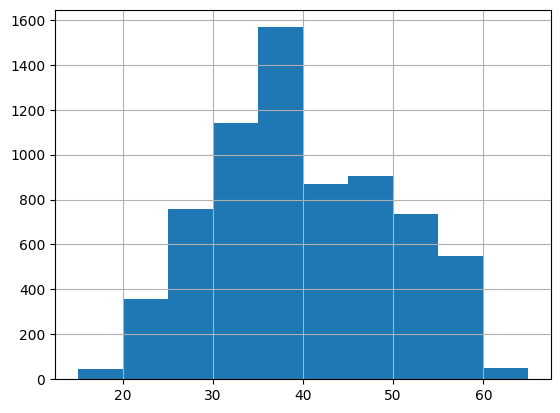

In [ ]:
#####################
# "Age"(年齢)の処理 #
#####################
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    # tmp = int(tmp)
    # # 10歳で分けて5足す
    # tmp = tmp//10 * 10
    # all_df.loc[i,"Age"] = tmp + 5
    # all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムの表示
all_df["Age"].hist()

In [ ]:
# 年代のラベリングを追加する
# all_df["AgeTeen"] = all_df["Age"]
# all_df["AgeTeen"] = all_df["AgeTeen"] // 10

<Axes: >

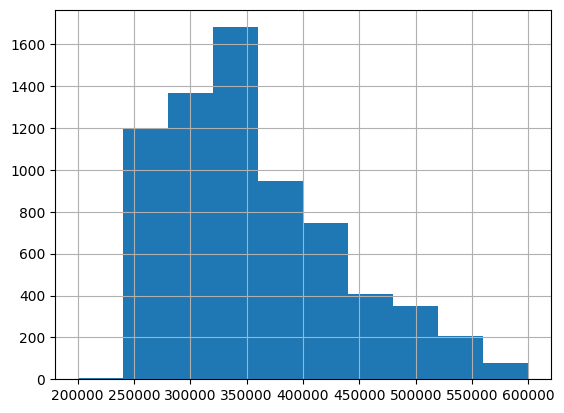

In [ ]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

<Axes: >

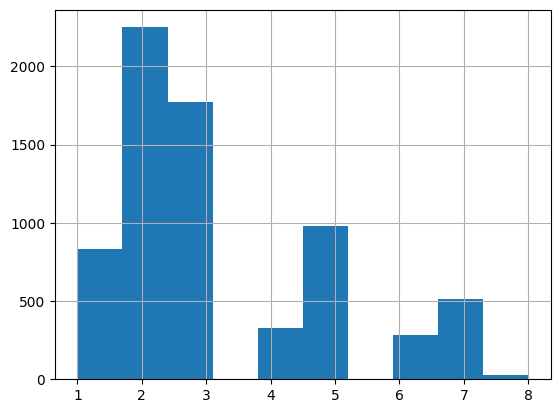

In [ ]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [ ]:
# 旅行回数を階層化
# all_df["Weight"] = 1
# all_df.loc[all_df["NumberOfTrips"]>=3,"Weight"] = 3
# all_df.loc[all_df["NumberOfTrips"]>=2,"Weight"] = 2

In [ ]:
###################################
# "TypeofContact"(連絡手段)の処理 #
###################################
# 欠損は最頻値で埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [ ]:
# 連絡手段の順序
Self = all_df.loc[all_df["TypeofContact"]=="Self Enquiry","NumberOfTrips"].median()
Company = all_df.loc[all_df["TypeofContact"]=="Company Invited","NumberOfTrips"].median()

print(Self)
print(Company)

# 旅行回数で割り当てる
# all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 3
# all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

3.0
2.0


In [ ]:
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2
all_df["TypeofContact"] = all_df["TypeofContact"].astype("int")

In [ ]:
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
1,4462
2,2516


In [ ]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
# (月収、年齢ともに差が無くラベル付けできない)
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


<Axes: >

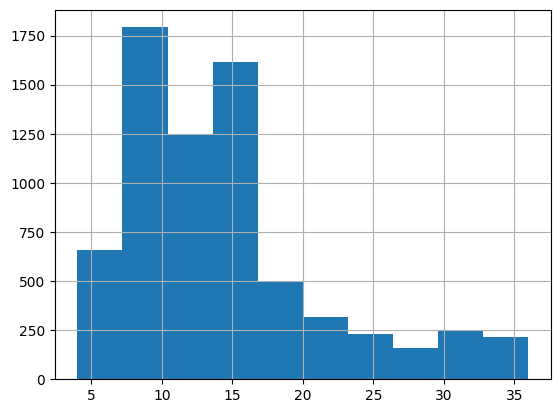

In [ ]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 分布の確認
all_df["DurationOfPitch"].hist()

In [ ]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [ ]:
print(all_df.loc[all_df["Occupation"]=="Small Business","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Salaried","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Large Business","NumberOfTrips"].median())

3.0
3.0
3.0


In [ ]:
# 「Occupation」をラベルエンコード(特徴見当たらず)
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
# all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2

In [ ]:
# 元の列を削除
all_df = all_df.drop("Occupation", axis=1)

In [ ]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

In [ ]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [ ]:
# ターゲットエンコーディング
# 男性の成約率が女性の1.5倍
print(all_df.loc[all_df["Gender"]=="Female","ProdTaken"].mean())
print(all_df.loc[all_df["Gender"]=="Male","ProdTaken"].mean())

0.13767629281396912
0.17025440313111545


In [ ]:
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
# all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
# all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=3
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=1

In [ ]:
# 元の列を削除
all_df = all_df.drop("Gender", axis=1)

In [ ]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [ ]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 欠損は自分以外の最頻値にする
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [ ]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [ ]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [ ]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [ ]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [ ]:
# 商品ランクの順序
Basic = all_df.loc[all_df["ProductPitched"]=="Basic","MonthlyIncome"].median()
Deluxe = all_df.loc[all_df["ProductPitched"]=="Deluxe","MonthlyIncome"].median()
Standard = all_df.loc[all_df["ProductPitched"]=="Standard","MonthlyIncome"].median()
SuperDeluxe = all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","MonthlyIncome"].median()
King = all_df.loc[all_df["ProductPitched"]=="King","MonthlyIncome"].median()

# Basicを基準とした商品ランクの間隔
base = Deluxe - Basic # これを「2」とする
print(round((Standard - Basic)/base*2))
print(round((SuperDeluxe - Basic)/base*2))
print(round((King - Basic)/base*2))

5
10
11


In [ ]:
# 「ProductPitched」をラベルエンコード
# all_df["ProductPitched_LE"] = 1
# all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=10
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=8
# all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=6
# all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=4
# all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=2

In [ ]:
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

In [ ]:
# 元の列を削除
all_df = all_df.drop("ProductPitched", axis=1)

In [ ]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [ ]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

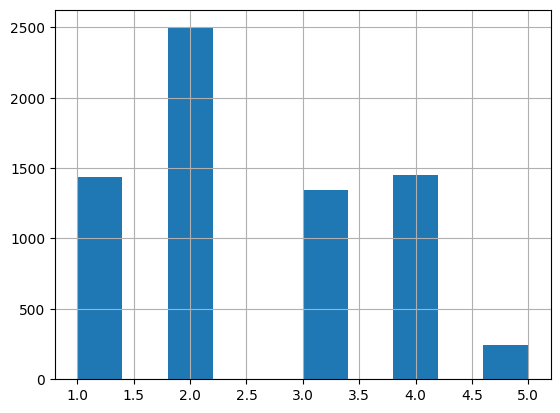

In [ ]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [ ]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [ ]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [ ]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [ ]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


300000.0
506745.0
474960.0
386752.5
336195.0


<Axes: >

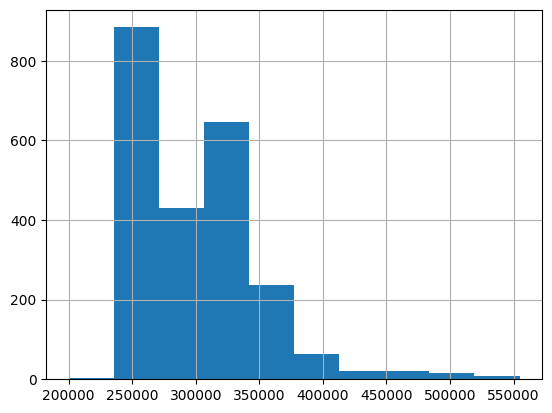

In [ ]:
# 最頻値で確認
print(all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median())

all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].hist()

In [ ]:
Executive = all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median()
VP = all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median()
AVP = all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median()
Senior = all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median()
Manager = all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median()

print(round((Manager - Executive)/Executive*10))
print(round((Senior - Executive)/Executive*10))
print(round((AVP - Executive)/Executive*10))
print(round((VP - Executive)/Executive*10))

1
3
6
7


In [ ]:
# 「Dsignation」をラベルエンコード
# 社長はほとんどが個人事業主のため給料安い。そのため低く見積もる
# all_df["Designation_LE"] = 1
# all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 10
# all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 8
# all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 6
# all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 4
# all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 2

In [ ]:
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

In [ ]:
# 元の列を削除
all_df = all_df.drop("Designation", axis=1)

In [ ]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [ ]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [ ]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [ ]:
all_df["CarHolder"] = all_df["CarHolder"] + 1

In [ ]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [ ]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


In [ ]:
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

In [ ]:
all_df = all_df.drop("Married", axis=1)

# 特徴量エンジニアリング

In [ ]:
# LOGを取る
all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])  # 月収はLogを取る
all_df["AgeLOG"] = np.log1p(all_df["Age"])  # 年齢はLogを取る

In [ ]:
# 列を削除
all_df = all_df.drop("MonthlyIncome", axis=1)
all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("ProductPitched_LE", axis=1)
# all_df = all_df.drop("Designation_LE", axis=1)

In [ ]:
all_df.columns

Index(['id', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'ProdTaken',
       'ProductPitched_LE', 'Designation_LE', 'Married_LE', 'MonthlyIncomeLOG',
       'AgeLOG'],
      dtype='object')

In [ ]:
# 列を追加で削除
all_df = all_df.drop("NumofChild", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("Occupation_LE", axis=1)

In [ ]:
# all_df = all_df.drop("NumberOfFollowups", axis=1)

KeyError: "['ProductPitched_LE'] not found in axis"

In [ ]:
# # クロス特徴量の追加
# 「役職」x「商品ランク」
all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

# (ボツ)「役職」x「月収」
# all_df["Designation_LE_MonthlyIncomeLOG"] = all_df["Designation_LE"] * all_df["MonthlyIncomeLOG"]
# # (ボツ)「商品ランク」x「満足度」
# all_df["ProductPitched_LE_PitchSatisfactionScore"] = all_df["ProductPitched_LE"] * all_df["PitchSatisfactionScore"]
# # (ボツ)「商品ランク」x「都市富裕度」
# all_df["ProductPitched_LE_CityTier_LE"] = all_df["ProductPitched_LE"] * all_df["CityTier"]
# # (ボツ)「月収」/「年齢」
# all_df["MonthlyIncomeLOG_AgeLOG"] = all_df["MonthlyIncomeLOG"] * all_df["AgeLOG"]
# # (ボツ)「月収」x「年間旅行数」
# all_df["MonthlyIncomeLOG_NumberOfTrips"] = all_df["MonthlyIncomeLOG"] * all_df["NumberOfTrips"]
# # (ボツ)「セールス時間」x「満足度」
# all_df["DurationOfPitch_PitchSatisfactionScore"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# # 「年間旅行数」x「満足度」
# all_df["NumberOfTrips_PitchSatisfactionScore"] = all_df["NumberOfTrips"] * all_df["PitchSatisfactionScore"]

In [ ]:
all_df = all_df.drop("Designation_LE_ProductPitched_LE", axis=1)

In [ ]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'MonthlyIncome',
       'ProdTaken', 'AgeTeen', 'Weight', 'Occupation_LE', 'Gender_LE',
       'ProductPitched_LE', 'Designation_LE', 'CarHolder', 'NumofChild',
       'Married_LE', 'MonthlyIncomeLOG', 'AgeLOG',
       'Designation_LE_ProductPitched_LE'],
      dtype='object')

In [ ]:
all_df = all_df.drop("Designation_LE_MonthlyIncomeLOG", axis=1)

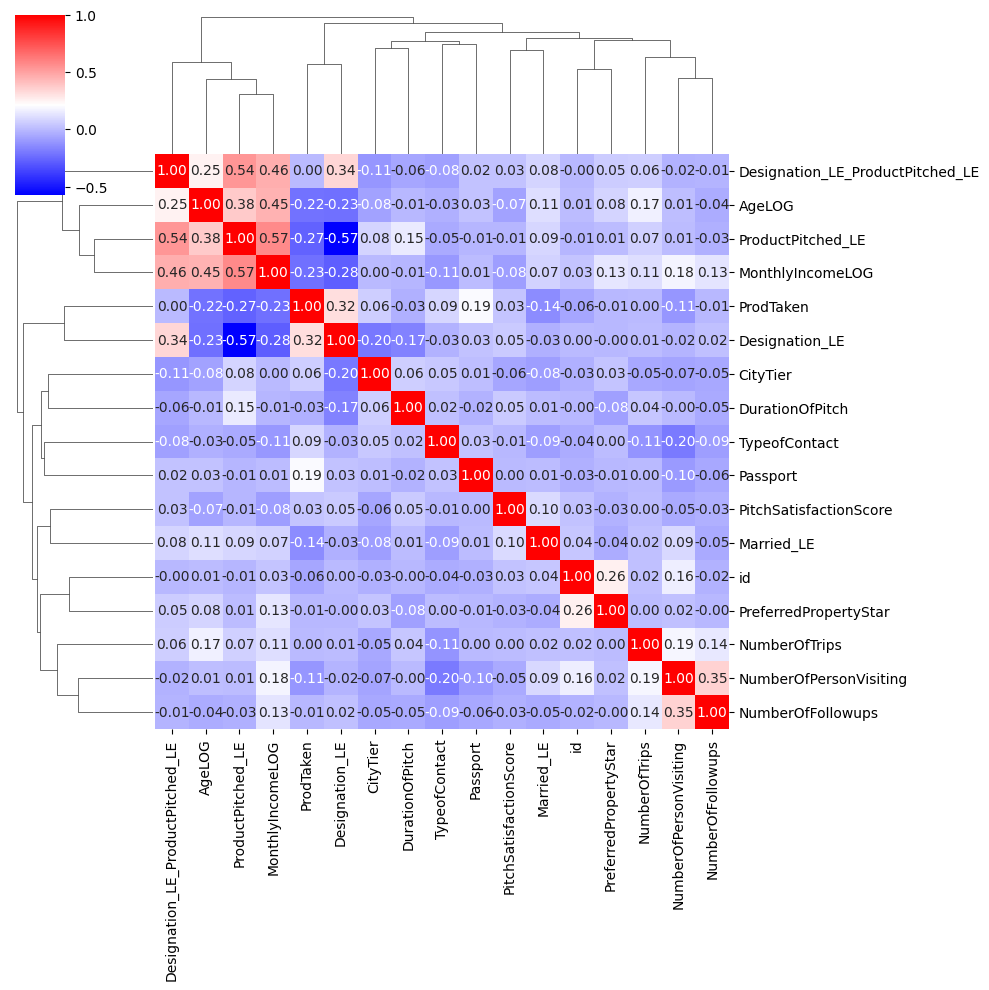

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("Occupation_LE", axis=1)
# all_df = all_df.drop("NumberOfFollowups", axis=1)
# all_df = all_df.drop("PreferredPropertyStar", axis=1)
# all_df = all_df.drop("Gender_LE", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)
# all_df = all_df.drop("Age", axis=1)

In [ ]:
all_df.columns

Index(['id', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'ProdTaken',
       'Weight', 'Occupation_LE', 'Gender_LE', 'Designation_LE', 'CarHolder',
       'NumofChild', 'Married_LE', 'MonthlyIncomeLOG', 'AgeLOG'],
      dtype='object')

In [ ]:
# # 検討の結果、重要度が低いものを抹消する
RMV3=['NumberOfPersonVisiting',
       'NumberOfTrips', 'PitchSatisfactionScore',
       'CarHolder_LE',
       'TypeofContact_LE', 'MonthlyIncomeLOG',
       ]
all_df = all_df.drop(RMV3, axis=1)

# ここから学習

In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [ ]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [ ]:
CATS

[]

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [ ]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [ ]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [ ]:
FEATURES = test.columns

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'learning_rate': 0.01,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-23 22:24:08,389] A new study created in memory with name: no-name-4b318440-1333-43a3-9a56-4e7d65d8cad0
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.797779
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.815815
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:11,210] Trial 0 finished with value: 0.8099257308557225 and parameters: {'num_leaves': 229, 'min_data_in_leaf': 14, 'feature_fraction': 0.9983338479887334, 'bagging_fraction': 0.8910265123580265, 'bagging_freq': 1, 'lambda_l1': 0.002917115502312272, 'lambda_l2': 0.11365874181018161, 'max_depth': 11}. Best is trial 0 with value: 0.8099257308557225.


[100]	train's auc: 1	valid's auc: 0.78729
#########################
### Fold 1
#########################
[100]	train's auc: 0.964634	valid's auc: 0.80144


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.960696	valid's auc: 0.830963
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:11,669] Trial 1 finished with value: 0.8220553266120789 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 46, 'feature_fraction': 0.747843430881175, 'bagging_fraction': 0.5301384345741295, 'bagging_freq': 5, 'lambda_l1': 0.000334369543981637, 'lambda_l2': 0.0015442355618411722, 'max_depth': 11}. Best is trial 1 with value: 0.8220553266120789.


[100]	train's auc: 0.96257	valid's auc: 0.791322
#########################
### Fold 1
#########################
[100]	train's auc: 0.929113	valid's auc: 0.815277


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.926705	valid's auc: 0.837084
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:12,141] Trial 2 finished with value: 0.8258272899428658 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 96, 'feature_fraction': 0.7883790444572054, 'bagging_fraction': 0.6737152200312231, 'bagging_freq': 3, 'lambda_l1': 0.012054348429998644, 'lambda_l2': 2.7614876217608326e-06, 'max_depth': 10}. Best is trial 2 with value: 0.8258272899428658.


[100]	train's auc: 0.930871	valid's auc: 0.810585
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 1	valid's auc: 0.796927
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.804764
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:13,130] Trial 3 finished with value: 0.7872959683233088 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 11, 'feature_fraction': 0.8713174219698006, 'bagging_fraction': 0.9373052837712229, 'bagging_freq': 2, 'lambda_l1': 0.0006583496547738037, 'lambda_l2': 0.10122649983286885, 'max_depth': 10}. Best is trial 2 with value: 0.8258272899428658.


[100]	train's auc: 1	valid's auc: 0.792482
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.947858	valid's auc: 0.815785
#########################
### Fold 2
#########################
[100]	train's auc: 0.945244	valid's auc: 0.834697
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:13,643] Trial 4 finished with value: 0.8224060270715201 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 83, 'feature_fraction': 0.8064486299905234, 'bagging_fraction': 0.7940177756669113, 'bagging_freq': 4, 'lambda_l1': 0.40120942705225626, 'lambda_l2': 1.4142852894556184e-06, 'max_depth': 10}. Best is trial 2 with value: 0.8258272899428658.


[100]	train's auc: 0.947898	valid's auc: 0.814502
[200]	train's auc: 0.981928	valid's auc: 0.800583
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.952591	valid's auc: 0.816353
#########################
### Fold 2
#########################
[100]	train's auc: 0.951386	valid's auc: 0.82773


[I 2025-05-23 22:24:14,225] Trial 5 finished with value: 0.8258202288597898 and parameters: {'num_leaves': 209, 'min_data_in_leaf': 59, 'feature_fraction': 0.6005243033308807, 'bagging_fraction': 0.6399907110918652, 'bagging_freq': 5, 'lambda_l1': 0.1817024327902994, 'lambda_l2': 1.9497879606794328e-08, 'max_depth': 10}. Best is trial 2 with value: 0.8258272899428658.


#########################
### Fold 3
#########################
[100]	train's auc: 0.949632	valid's auc: 0.808751
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885404	valid's auc: 0.820032
#########################
### Fold 2
#########################
[100]	train's auc: 0.879189	valid's auc: 0.853663
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:14,633] Trial 6 finished with value: 0.8331418995254951 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 80, 'feature_fraction': 0.5045778219140226, 'bagging_fraction': 0.5976222731651214, 'bagging_freq': 1, 'lambda_l1': 1.1779130125963321e-08, 'lambda_l2': 1.2729004585914544e-08, 'max_depth': 3}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.889895	valid's auc: 0.820204
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904403	valid's auc: 0.817156
#########################
### Fold 2
#########################
[100]	train's auc: 0.901621	valid's auc: 0.845222
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:15,265] Trial 7 finished with value: 0.8253750443839508 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 75, 'feature_fraction': 0.8403837338535427, 'bagging_fraction': 0.848728858279147, 'bagging_freq': 4, 'lambda_l1': 3.4780058696916467, 'lambda_l2': 2.66710747514523e-07, 'max_depth': 5}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.90866	valid's auc: 0.810864
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.981855	valid's auc: 0.803984
#########################
### Fold 2
#########################
[100]	train's auc: 0.985932	valid's auc: 0.82393
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:15,778] Trial 8 finished with value: 0.8179430863254394 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 45, 'feature_fraction': 0.9834744360352456, 'bagging_fraction': 0.835651231837954, 'bagging_freq': 1, 'lambda_l1': 9.47754682712345e-06, 'lambda_l2': 1.754998823033496e-08, 'max_depth': 7}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.984795	valid's auc: 0.798093
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.93022	valid's auc: 0.818884
#########################
### Fold 2
#########################
[100]	train's auc: 0.93217	valid's auc: 0.840908


[I 2025-05-23 22:24:16,351] Trial 9 finished with value: 0.8254964277644476 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 79, 'feature_fraction': 0.998232738050377, 'bagging_fraction': 0.8917405714218702, 'bagging_freq': 3, 'lambda_l1': 5.753675677092058e-06, 'lambda_l2': 8.792148541567371, 'max_depth': 10}. Best is trial 6 with value: 0.8331418995254951.


#########################
### Fold 3
#########################
[100]	train's auc: 0.932217	valid's auc: 0.80518


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877961	valid's auc: 0.817464
#########################
### Fold 2
#########################
[100]	train's auc: 0.870277	valid's auc: 0.860573
#########################
### Fold 3
#########################
[100]	train's auc: 0.878974	valid's auc: 0.81735
[200]	train's auc: 0.901454	valid's auc: 0.82103


[I 2025-05-23 22:24:16,873] Trial 10 finished with value: 0.8326365277224848 and parameters: {'num_leaves': 29, 'min_data_in_leaf': 100, 'feature_fraction': 0.5015627282246204, 'bagging_fraction': 0.5028538365457926, 'bagging_freq': 7, 'lambda_l1': 5.7880677348022e-08, 'lambda_l2': 0.00011549205773017996, 'max_depth': 3}. Best is trial 6 with value: 0.8331418995254951.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.876206	valid's auc: 0.819712
#########################
### Fold 2
#########################
[100]	train's auc: 0.868881	valid's auc: 0.858823
#########################
### Fold 3
#########################
[100]	train's auc: 0.879407	valid's auc: 0.816779
[200]	train's auc: 0.901547	valid's auc: 0.819111


[I 2025-05-23 22:24:17,399] Trial 11 finished with value: 0.8325871001409526 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 100, 'feature_fraction': 0.5030694361681856, 'bagging_fraction': 0.5087234060203338, 'bagging_freq': 7, 'lambda_l1': 4.434496129913256e-08, 'lambda_l2': 0.00013796691425774004, 'max_depth': 3}. Best is trial 6 with value: 0.8331418995254951.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885287	valid's auc: 0.821362
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:17,872] Trial 12 finished with value: 0.8316879888959424 and parameters: {'num_leaves': 21, 'min_data_in_leaf': 66, 'feature_fraction': 0.5077482336138722, 'bagging_fraction': 0.611373102878343, 'bagging_freq': 7, 'lambda_l1': 1.2968611741816038e-08, 'lambda_l2': 7.4243491296246e-05, 'max_depth': 3}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.884526	valid's auc: 0.851975
#########################
### Fold 3
#########################
[100]	train's auc: 0.88868	valid's auc: 0.816907


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907459	valid's auc: 0.814939
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:18,372] Trial 13 finished with value: 0.8299718094664242 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 90, 'feature_fraction': 0.6185726574517061, 'bagging_fraction': 0.5768374396773162, 'bagging_freq': 6, 'lambda_l1': 7.821191109618173e-07, 'lambda_l2': 0.0032874508472996214, 'max_depth': 5}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.907152	valid's auc: 0.850491
#########################
### Fold 3
#########################
[100]	train's auc: 0.902651	valid's auc: 0.814957


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929687	valid's auc: 0.814921
#########################
### Fold 2
#########################
[100]	train's auc: 0.927688	valid's auc: 0.840673
#########################
### Fold 3
#########################
[100]	train's auc: 0.929657	valid's auc: 0.8075


[I 2025-05-23 22:24:18,867] Trial 14 finished with value: 0.8249140565317037 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 71, 'feature_fraction': 0.5972036391325882, 'bagging_fraction': 0.6869755199921002, 'bagging_freq': 2, 'lambda_l1': 2.85855902179049e-07, 'lambda_l2': 8.855318981970402e-06, 'max_depth': 5}. Best is trial 6 with value: 0.8331418995254951.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.931339	valid's auc: 0.812546
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:19,363] Trial 15 finished with value: 0.829967102077707 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 91, 'feature_fraction': 0.6562767925964316, 'bagging_fraction': 0.7094011897396169, 'bagging_freq': 6, 'lambda_l1': 2.8743520690268983e-05, 'lambda_l2': 0.021109202162077335, 'max_depth': 7}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.933164	valid's auc: 0.840509
#########################
### Fold 3
#########################
[100]	train's auc: 0.928573	valid's auc: 0.813324


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897287	valid's auc: 0.817815
#########################
### Fold 2
#########################
[100]	train's auc: 0.897747	valid's auc: 0.848763
#########################
### Fold 3
#########################
[100]	train's auc: 0.903691	valid's auc: 0.817301


[I 2025-05-23 22:24:19,937] Trial 16 finished with value: 0.8268138241211977 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 33, 'feature_fraction': 0.7043996264814651, 'bagging_fraction': 0.5805139296762583, 'bagging_freq': 3, 'lambda_l1': 1.691331237974957e-07, 'lambda_l2': 9.972797966888178, 'max_depth': 4}. Best is trial 6 with value: 0.8331418995254951.


[200]	train's auc: 0.928786	valid's auc: 0.812279
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.912199	valid's auc: 0.821428
#########################
### Fold 2
#########################
[100]	train's auc: 0.906223	valid's auc: 0.844238
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:20,542] Trial 17 finished with value: 0.8307673581596531 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 86, 'feature_fraction': 0.5549035069122343, 'bagging_fraction': 0.555936713490895, 'bagging_freq': 5, 'lambda_l1': 1.6430347921229326e-06, 'lambda_l2': 1.573215394605009e-07, 'max_depth': 6}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.912628	valid's auc: 0.816591


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885769	valid's auc: 0.820498
#########################
### Fold 2
#########################
[100]	train's auc: 0.8806	valid's auc: 0.850793
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:23,720] Trial 18 finished with value: 0.8280263129579616 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 100, 'feature_fraction': 0.5575029597173099, 'bagging_fraction': 0.7251291448877251, 'bagging_freq': 2, 'lambda_l1': 1.3510606300277792e-08, 'lambda_l2': 1.578492355943997e-05, 'max_depth': 3}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.886813	valid's auc: 0.817459
[200]	train's auc: 0.90883	valid's auc: 0.821109
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.907055	valid's auc: 0.805839
#########################
### Fold 2
#########################
[100]	train's auc: 0.900947	valid's auc: 0.849361
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:24,102] Trial 19 finished with value: 0.8278433972820883 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 62, 'feature_fraction': 0.6661486131503656, 'bagging_fraction': 0.503645677788723, 'bagging_freq': 6, 'lambda_l1': 1.0239159470620374e-07, 'lambda_l2': 1.793268476079352e-07, 'max_depth': 4}. Best is trial 6 with value: 0.8331418995254951.


[100]	train's auc: 0.905765	valid's auc: 0.811417
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.95014	valid's auc: 0.816673
#########################
### Fold 2
#########################
[100]	train's auc: 0.952355	valid's auc: 0.840516


[I 2025-05-23 22:24:24,706] Trial 20 finished with value: 0.8313833535975208 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 52, 'feature_fraction': 0.5529143584178858, 'bagging_fraction': 0.6285096196078722, 'bagging_freq': 1, 'lambda_l1': 3.5865426548102675e-05, 'lambda_l2': 0.8046570067878956, 'max_depth': 8}. Best is trial 6 with value: 0.8331418995254951.


#########################
### Fold 3
#########################
[100]	train's auc: 0.952543	valid's auc: 0.819785
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876041	valid's auc: 0.822214
#########################
### Fold 2
#########################
[100]	train's auc: 0.869436	valid's auc: 0.861488


[I 2025-05-23 22:24:25,221] Trial 21 finished with value: 0.8359337172769234 and parameters: {'num_leaves': 22, 'min_data_in_leaf': 99, 'feature_fraction': 0.5168980123335377, 'bagging_fraction': 0.5036560280560451, 'bagging_freq': 7, 'lambda_l1': 4.435856993474161e-08, 'lambda_l2': 0.0003264070743425827, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[200]	train's auc: 0.893157	valid's auc: 0.852032
#########################
### Fold 3
#########################
[100]	train's auc: 0.877992	valid's auc: 0.819384
[200]	train's auc: 0.899153	valid's auc: 0.821376


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893245	valid's auc: 0.816516
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:25,671] Trial 22 finished with value: 0.8329445254414186 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 92, 'feature_fraction': 0.5227940743807391, 'bagging_fraction': 0.5599084524159829, 'bagging_freq': 7, 'lambda_l1': 1.1266570798754085e-08, 'lambda_l2': 0.0016623417730930116, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.892081	valid's auc: 0.85515
#########################
### Fold 3
#########################
[100]	train's auc: 0.889842	valid's auc: 0.817872


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898471	valid's auc: 0.818044
#########################
### Fold 2
#########################
[100]	train's auc: 0.894283	valid's auc: 0.846745
#########################
### Fold 3
#########################
[100]	train's auc: 0.894208	valid's auc: 0.823823
[200]	train's auc: 0.92767	valid's auc: 0.813779


[I 2025-05-23 22:24:26,155] Trial 23 finished with value: 0.8234356002324106 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 81, 'feature_fraction': 0.5597641749224289, 'bagging_fraction': 0.5545829258033302, 'bagging_freq': 6, 'lambda_l1': 1.5776709888214008e-08, 'lambda_l2': 0.001052056541475963, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.896937	valid's auc: 0.820214
#########################
### Fold 2
#########################
[100]	train's auc: 0.899348	valid's auc: 0.846576
#########################
### Fold 3
#########################
[100]	train's auc: 0.896213	valid's auc: 0.815267


[I 2025-05-23 22:24:26,699] Trial 24 finished with value: 0.830322173683814 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 91, 'feature_fraction': 0.6358063219011685, 'bagging_fraction': 0.6087663284690846, 'bagging_freq': 7, 'lambda_l1': 8.427005547346543e-07, 'lambda_l2': 0.006338401229741485, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[200]	train's auc: 0.92951	valid's auc: 0.810852
#########################
### Fold 1
#########################
[100]	train's auc: 0.939954	valid's auc: 0.818522


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.943523	valid's auc: 0.841295
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:27,219] Trial 25 finished with value: 0.8294714812941821 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 71, 'feature_fraction': 0.536462502523618, 'bagging_fraction': 0.7625438222694488, 'bagging_freq': 5, 'lambda_l1': 1.0955098408748912e-08, 'lambda_l2': 0.0005987927248529099, 'max_depth': 6}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.941211	valid's auc: 0.809941
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.886176	valid's auc: 0.81851
#########################
### Fold 2
#########################
[100]	train's auc: 0.883808	valid's auc: 0.851198
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:27,735] Trial 26 finished with value: 0.8305720015278839 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 87, 'feature_fraction': 0.7023187962402563, 'bagging_fraction': 0.6629200887220381, 'bagging_freq': 6, 'lambda_l1': 4.04045553828808e-07, 'lambda_l2': 0.013546929677471639, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.890353	valid's auc: 0.819743
[200]	train's auc: 0.914518	valid's auc: 0.81755
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.915243	valid's auc: 0.808135
#########################
### Fold 2
#########################
[100]	train's auc: 0.9197	valid's auc: 0.842576
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:28,268] Trial 27 finished with value: 0.8250451909316865 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 78, 'feature_fraction': 0.5865583390651082, 'bagging_fraction': 0.5446020772150859, 'bagging_freq': 7, 'lambda_l1': 2.1934014898356974e-06, 'lambda_l2': 1.8851166651655915e-05, 'max_depth': 6}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.913977	valid's auc: 0.814392
[200]	train's auc: 0.95002	valid's auc: 0.802344
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917325	valid's auc: 0.816552
#########################
### Fold 2
#########################
[100]	train's auc: 0.914357	valid's auc: 0.841464
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:28,823] Trial 28 finished with value: 0.8266668863448068 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 95, 'feature_fraction': 0.9342288496240735, 'bagging_fraction': 0.5883799080731905, 'bagging_freq': 4, 'lambda_l1': 1.033233248169715e-07, 'lambda_l2': 0.00031427172575932257, 'max_depth': 8}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.920126	valid's auc: 0.811435
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.940651	valid's auc: 0.809736
#########################
### Fold 2
#########################
[100]	train's auc: 0.940858	valid's auc: 0.843899
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:29,273] Trial 29 finished with value: 0.8278403711036272 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 23, 'feature_fraction': 0.5322572770707397, 'bagging_fraction': 0.9854123322819257, 'bagging_freq': 1, 'lambda_l1': 0.008783086260779617, 'lambda_l2': 0.050871490929391916, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.939229	valid's auc: 0.811496
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.938837	valid's auc: 0.817307
#########################
### Fold 2
#########################
[100]	train's auc: 0.941502	valid's auc: 0.843706
#########################
### Fold 3
#########################
[100]	train's auc: 0.942384	valid's auc: 0.811362


[I 2025-05-23 22:24:29,893] Trial 30 finished with value: 0.8256672387264765 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 71, 'feature_fraction': 0.5822007080858441, 'bagging_fraction': 0.646816592004104, 'bagging_freq': 7, 'lambda_l1': 7.21866214267665e-05, 'lambda_l2': 0.2293613126581818, 'max_depth': 12}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.878426	valid's auc: 0.822044
#########################
### Fold 2
#########################
[100]	train's auc: 0.869686	valid's auc: 0.858301
#########################
### Fold 3
#########################
[100]	train's auc: 0.879211	valid's auc: 0.818073


[I 2025-05-23 22:24:30,418] Trial 31 finished with value: 0.8325319564445497 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 95, 'feature_fraction': 0.5032042295093068, 'bagging_fraction': 0.5073082279155977, 'bagging_freq': 7, 'lambda_l1': 6.732433570609643e-08, 'lambda_l2': 7.207943572438203e-05, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[200]	train's auc: 0.90158	valid's auc: 0.822712
#########################
### Fold 1
#########################
[100]	train's auc: 0.881289	valid's auc: 0.820999


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.871766	valid's auc: 0.855153
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:30,894] Trial 32 finished with value: 0.8329297307911641 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 100, 'feature_fraction': 0.5207785683082998, 'bagging_fraction': 0.5347340470720461, 'bagging_freq': 6, 'lambda_l1': 5.180131286533437e-08, 'lambda_l2': 0.0002556780103604969, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.878327	valid's auc: 0.820745
[200]	train's auc: 0.902994	valid's auc: 0.812923
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.901047	valid's auc: 0.816739
#########################
### Fold 2
#########################
[100]	train's auc: 0.899489	valid's auc: 0.846192
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:31,394] Trial 33 finished with value: 0.8274849632554686 and parameters: {'num_leaves': 250, 'min_data_in_leaf': 93, 'feature_fraction': 0.5330855027616307, 'bagging_fraction': 0.5468528864235978, 'bagging_freq': 6, 'lambda_l1': 4.1588931189202534e-08, 'lambda_l2': 2.2969378403330974e-06, 'max_depth': 5}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.898263	valid's auc: 0.820842
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.90104	valid's auc: 0.81712
#########################
### Fold 2
#########################
[100]	train's auc: 0.897258	valid's auc: 0.848268
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:31,916] Trial 34 finished with value: 0.8310114698888519 and parameters: {'num_leaves': 19, 'min_data_in_leaf': 85, 'feature_fraction': 0.5811005909481596, 'bagging_fraction': 0.5960826326998181, 'bagging_freq': 5, 'lambda_l1': 2.474468968421225e-07, 'lambda_l2': 0.0027219301707098647, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.89992	valid's auc: 0.821552
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883773	valid's auc: 0.820486
#########################
### Fold 2
#########################
[100]	train's auc: 0.87227	valid's auc: 0.853875
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:32,414] Trial 35 finished with value: 0.8338517064956585 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 88, 'feature_fraction': 0.5273689947734506, 'bagging_fraction': 0.5273083538484258, 'bagging_freq': 6, 'lambda_l1': 0.000735188970078322, 'lambda_l2': 6.024511094924653e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.879532	valid's auc: 0.822657
[200]	train's auc: 0.904377	valid's auc: 0.820951
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898709	valid's auc: 0.823144
#########################
### Fold 2
#########################
[100]	train's auc: 0.896269	valid's auc: 0.845283
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:33,011] Trial 36 finished with value: 0.8331028954475517 and parameters: {'num_leaves': 37, 'min_data_in_leaf': 86, 'feature_fraction': 0.6260137518021255, 'bagging_fraction': 0.5683054109774269, 'bagging_freq': 3, 'lambda_l1': 0.0006109659758025652, 'lambda_l2': 5.92975990799163e-08, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.901803	valid's auc: 0.822117
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.91103	valid's auc: 0.821694
#########################
### Fold 2
#########################
[100]	train's auc: 0.910744	valid's auc: 0.837942


[I 2025-05-23 22:24:36,444] Trial 37 finished with value: 0.8322838098107361 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 77, 'feature_fraction': 0.7250674717739984, 'bagging_fraction': 0.5264342873639696, 'bagging_freq': 3, 'lambda_l1': 0.0011618626860256302, 'lambda_l2': 5.684439631707188e-08, 'max_depth': 5}. Best is trial 21 with value: 0.8359337172769234.


#########################
### Fold 3
#########################
[100]	train's auc: 0.915998	valid's auc: 0.819238


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883313	valid's auc: 0.822232
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:36,932] Trial 38 finished with value: 0.8301204284530714 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 83, 'feature_fraction': 0.7653772863507421, 'bagging_fraction': 0.5738609287585226, 'bagging_freq': 2, 'lambda_l1': 0.00013312218780130294, 'lambda_l2': 5.680271514453127e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.883331	valid's auc: 0.851446
#########################
### Fold 3
#########################
[100]	train's auc: 0.890435	valid's auc: 0.819232


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.961076	valid's auc: 0.814256
#########################
### Fold 2
#########################
[100]	train's auc: 0.961594	valid's auc: 0.833362
#########################
### Fold 3
#########################
[100]	train's auc: 0.95896	valid's auc: 0.807646


[I 2025-05-23 22:24:37,462] Trial 39 finished with value: 0.8275562465703311 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 55, 'feature_fraction': 0.6515147173902786, 'bagging_fraction': 0.6296872599945631, 'bagging_freq': 4, 'lambda_l1': 0.06393567326549991, 'lambda_l2': 3.984745839896188e-08, 'max_depth': 9}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.92917	valid's auc: 0.815918
#########################
### Fold 2
#########################
[100]	train's auc: 0.92826	valid's auc: 0.848141
#########################
### Fold 3
#########################
[100]	train's auc: 0.931566	valid's auc: 0.815006


[I 2025-05-23 22:24:38,042] Trial 40 finished with value: 0.8303598327935527 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 39, 'feature_fraction': 0.6166540558189624, 'bagging_fraction': 0.6840221512122373, 'bagging_freq': 1, 'lambda_l1': 0.0028448446392047035, 'lambda_l2': 1.2865365232328302e-08, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897411	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.893634	valid's auc: 0.849331
#########################
### Fold 3
#########################
[100]	train's auc: 0.899644	valid's auc: 0.82468
[200]	train's auc: 0.928301	valid's auc: 0.821892


[I 2025-05-23 22:24:38,613] Trial 41 finished with value: 0.8329277133388566 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 88, 'feature_fraction': 0.5713246382508758, 'bagging_fraction': 0.5289892836680316, 'bagging_freq': 3, 'lambda_l1': 0.0004083752006632344, 'lambda_l2': 4.866980866659532e-08, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883435	valid's auc: 0.822437
#########################
### Fold 2
#########################
[100]	train's auc: 0.875997	valid's auc: 0.853863
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:39,265] Trial 42 finished with value: 0.831237760789335 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 81, 'feature_fraction': 0.5331250966792193, 'bagging_fraction': 0.5697696704526781, 'bagging_freq': 5, 'lambda_l1': 0.009657521509065955, 'lambda_l2': 1.0001583065971414e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.884299	valid's auc: 0.81588
[200]	train's auc: 0.907991	valid's auc: 0.815643
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.901498	valid's auc: 0.82135
#########################
### Fold 2
#########################
[100]	train's auc: 0.906632	valid's auc: 0.844757
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:39,888] Trial 43 finished with value: 0.828493353167131 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 95, 'feature_fraction': 0.6148814231903466, 'bagging_fraction': 0.6092572852159206, 'bagging_freq': 7, 'lambda_l1': 0.05596307490988777, 'lambda_l2': 9.90090788707289e-07, 'max_depth': 5}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.90043	valid's auc: 0.813961
[200]	train's auc: 0.936055	valid's auc: 0.808805


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885938	valid's auc: 0.829017
#########################
### Fold 2
#########################
[100]	train's auc: 0.876321	valid's auc: 0.848884
#########################
### Fold 3
#########################
[100]	train's auc: 0.885608	valid's auc: 0.823574


[I 2025-05-23 22:24:40,449] Trial 44 finished with value: 0.8342477996320168 and parameters: {'num_leaves': 48, 'min_data_in_leaf': 73, 'feature_fraction': 0.5468617844443787, 'bagging_fraction': 0.5269610680232942, 'bagging_freq': 3, 'lambda_l1': 0.0012559273576682047, 'lambda_l2': 4.2241835619662225e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887221	valid's auc: 0.825029
#########################
### Fold 2
#########################
[100]	train's auc: 0.886473	valid's auc: 0.841229
#########################
### Fold 3
#########################
[100]	train's auc: 0.895707	valid's auc: 0.818394


[I 2025-05-23 22:24:40,992] Trial 45 finished with value: 0.8298531160223372 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 68, 'feature_fraction': 0.8398228432952369, 'bagging_fraction': 0.5256441494100432, 'bagging_freq': 3, 'lambda_l1': 0.002382859565850522, 'lambda_l2': 4.1743534802003844e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[200]	train's auc: 0.91609	valid's auc: 0.814988
#########################
### Fold 1
#########################
[100]	train's auc: 0.881459	valid's auc: 0.818105


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.903447	valid's auc: 0.817132
#########################
### Fold 2
#########################
[100]	train's auc: 0.875503	valid's auc: 0.857083
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:41,542] Trial 46 finished with value: 0.830801318606828 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 74, 'feature_fraction': 0.5433035949440707, 'bagging_fraction': 0.5016563086282443, 'bagging_freq': 2, 'lambda_l1': 0.00022870807598873694, 'lambda_l2': 5.654868595618865e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.884516	valid's auc: 0.813949
#########################
### Fold 1
#########################
[100]	train's auc: 0.892459	valid's auc: 0.821271


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888457	valid's auc: 0.853875
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:42,059] Trial 47 finished with value: 0.8335917913900516 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 74, 'feature_fraction': 0.5964171838289445, 'bagging_fraction': 0.8024904820200085, 'bagging_freq': 4, 'lambda_l1': 0.0008449785050918849, 'lambda_l2': 9.642919740435705e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.897226	valid's auc: 0.819105
#########################
### Fold 1
#########################
[100]	train's auc: 0.884273	valid's auc: 0.820522


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.903737	valid's auc: 0.820939
#########################
### Fold 2
#########################
[100]	train's auc: 0.875271	valid's auc: 0.85399
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:42,680] Trial 48 finished with value: 0.8297845226438848 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 63, 'feature_fraction': 0.506058470796532, 'bagging_fraction': 0.8580065305402498, 'bagging_freq': 4, 'lambda_l1': 2.7464364970342525, 'lambda_l2': 1.5279275652457806e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.885378	valid's auc: 0.819979
[200]	train's auc: 0.903063	valid's auc: 0.819487


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929553	valid's auc: 0.816063
#########################
### Fold 2
#########################
[100]	train's auc: 0.929791	valid's auc: 0.838842
#########################
### Fold 3
#########################
[100]	train's auc: 0.929261	valid's auc: 0.817405


[I 2025-05-23 22:24:43,294] Trial 49 finished with value: 0.8292630112224147 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 76, 'feature_fraction': 0.6000651810475293, 'bagging_fraction': 0.7981719143850712, 'bagging_freq': 5, 'lambda_l1': 1.2120391608302834e-05, 'lambda_l2': 3.4152742592246586e-05, 'max_depth': 5}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.969814	valid's auc: 0.795912
#########################
### Fold 2
#########################
[100]	train's auc: 0.971866	valid's auc: 0.827507
#########################
### Fold 3
#########################
[100]	train's auc: 0.971173	valid's auc: 0.810105


[I 2025-05-23 22:24:43,875] Trial 50 finished with value: 0.824944318316315 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 59, 'feature_fraction': 0.5749135326416155, 'bagging_fraction': 0.7700260884616774, 'bagging_freq': 4, 'lambda_l1': 0.03815522453724385, 'lambda_l2': 3.331534339039269e-06, 'max_depth': 11}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893483	valid's auc: 0.821192
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:44,327] Trial 51 finished with value: 0.8315353350046806 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 83, 'feature_fraction': 0.6412181451862965, 'bagging_fraction': 0.7972199904694506, 'bagging_freq': 4, 'lambda_l1': 0.0006128568637978835, 'lambda_l2': 9.121916767390135e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.887489	valid's auc: 0.853464
#########################
### Fold 3
#########################
[100]	train's auc: 0.896216	valid's auc: 0.819828


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.910601	valid's auc: 0.822546
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:44,826] Trial 52 finished with value: 0.8330675900321717 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 74, 'feature_fraction': 0.5607443479625105, 'bagging_fraction': 0.7352052630636382, 'bagging_freq': 3, 'lambda_l1': 0.001444448721815232, 'lambda_l2': 3.228431194714191e-08, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.912574	valid's auc: 0.848358
#########################
### Fold 3
#########################
[100]	train's auc: 0.913651	valid's auc: 0.817666


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880119	valid's auc: 0.822739
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:45,304] Trial 53 finished with value: 0.8325867638989014 and parameters: {'num_leaves': 45, 'min_data_in_leaf': 87, 'feature_fraction': 0.519655275286688, 'bagging_fraction': 0.5188751233810489, 'bagging_freq': 2, 'lambda_l1': 0.006679098325980068, 'lambda_l2': 1.2631905730510022e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.871272	valid's auc: 0.856153
#########################
### Fold 3
#########################
[100]	train's auc: 0.884961	valid's auc: 0.819409


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.924976	valid's auc: 0.814993
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:45,798] Trial 54 finished with value: 0.830384042221242 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 66, 'feature_fraction': 0.6916908153458525, 'bagging_fraction': 0.8954373860986922, 'bagging_freq': 3, 'lambda_l1': 0.0001418765704081976, 'lambda_l2': 1.1078210044210262e-07, 'max_depth': 4}. Best is trial 21 with value: 0.8359337172769234.


[100]	train's auc: 0.924029	valid's auc: 0.845053
#########################
### Fold 3
#########################
[100]	train's auc: 0.923647	valid's auc: 0.813633


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.896401	valid's auc: 0.823621
#########################
### Fold 2
#########################
[100]	train's auc: 0.893154	valid's auc: 0.852044
#########################
### Fold 3
#########################
[100]	train's auc: 0.896211	valid's auc: 0.817283


[I 2025-05-23 22:24:49,146] Trial 55 finished with value: 0.8327942252445152 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 80, 'feature_fraction': 0.6713759760957794, 'bagging_fraction': 0.8188470603845175, 'bagging_freq': 3, 'lambda_l1': 0.001079508146414826, 'lambda_l2': 3.150267332566674e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879081	valid's auc: 0.825911
#########################
### Fold 2
#########################
[100]	train's auc: 0.880254	valid's auc: 0.852745
#########################
### Fold 3
#########################
[100]	train's auc: 0.883758	valid's auc: 0.82358


[I 2025-05-23 22:24:49,655] Trial 56 finished with value: 0.8344740905324999 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 98, 'feature_fraction': 0.6111186076930414, 'bagging_fraction': 0.5483132740753666, 'bagging_freq': 1, 'lambda_l1': 0.021996977280654775, 'lambda_l2': 7.382657995041443e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8359337172769234.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877914	valid's auc: 0.827108
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:50,171] Trial 57 finished with value: 0.8364259756399359 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 98, 'feature_fraction': 0.5954037598784175, 'bagging_fraction': 0.5421805492671873, 'bagging_freq': 1, 'lambda_l1': 0.5568005757797188, 'lambda_l2': 2.3926514334770056e-08, 'max_depth': 3}. Best is trial 57 with value: 0.8364259756399359.


[100]	train's auc: 0.874887	valid's auc: 0.856757
#########################
### Fold 3
#########################
[100]	train's auc: 0.883094	valid's auc: 0.821886


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877363	valid's auc: 0.826914
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:50,672] Trial 58 finished with value: 0.8353136869344407 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 99, 'feature_fraction': 0.6025629649623973, 'bagging_fraction': 0.5447410110789689, 'bagging_freq': 1, 'lambda_l1': 0.6279079199481121, 'lambda_l2': 7.564180826233127e-07, 'max_depth': 3}. Best is trial 57 with value: 0.8364259756399359.


[100]	train's auc: 0.874849	valid's auc: 0.854068
#########################
### Fold 3
#########################
[100]	train's auc: 0.882399	valid's auc: 0.821133


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887056	valid's auc: 0.831428
#########################
### Fold 2
#########################
[100]	train's auc: 0.883509	valid's auc: 0.856467
#########################
### Fold 3
#########################
[100]	train's auc: 0.887409	valid's auc: 0.816664


[I 2025-05-23 22:24:51,258] Trial 59 finished with value: 0.835811325170273 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 97, 'feature_fraction': 0.6098111238886066, 'bagging_fraction': 0.5411887683499185, 'bagging_freq': 1, 'lambda_l1': 1.0831065987935136, 'lambda_l2': 7.515688533302496e-07, 'max_depth': 4}. Best is trial 57 with value: 0.8364259756399359.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889697	valid's auc: 0.829881
#########################
### Fold 2
#########################
[100]	train's auc: 0.887321	valid's auc: 0.851029
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:51,889] Trial 60 finished with value: 0.8370322200583177 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 97, 'feature_fraction': 0.6859353213004292, 'bagging_fraction': 0.5471914578129947, 'bagging_freq': 1, 'lambda_l1': 1.0544711704475207, 'lambda_l2': 7.004409091259165e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.889819	valid's auc: 0.818759
#########################
### Fold 1
#########################
[100]	train's auc: 0.893595	valid's auc: 0.827772


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.891313	valid's auc: 0.850461
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:52,426] Trial 61 finished with value: 0.8350292261590936 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 97, 'feature_fraction': 0.6668243731630636, 'bagging_fraction': 0.5490613114995143, 'bagging_freq': 1, 'lambda_l1': 0.6293651711819159, 'lambda_l2': 6.322524339715895e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.893423	valid's auc: 0.817344
#########################
### Fold 1
#########################
[100]	train's auc: 0.890736	valid's auc: 0.831319


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.886238	valid's auc: 0.849645
#########################
### Fold 3
#########################


[I 2025-05-23 22:24:52,952] Trial 62 finished with value: 0.8357874519846351 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 98, 'feature_fraction': 0.6769987538029143, 'bagging_fraction': 0.5535739335057781, 'bagging_freq': 1, 'lambda_l1': 1.1050978927490192, 'lambda_l2': 9.266647854388187e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.890707	valid's auc: 0.819214
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.900182	valid's auc: 0.824606
[200]	train's auc: 0.929243	valid's auc: 0.824413
#########################
### Fold 2
#########################
[100]	train's auc: 0.897987	valid's auc: 0.843609
#########################
### Fold 3
#########################
[100]	train's auc: 0.902699	valid's auc: 0.818753


[I 2025-05-23 22:24:53,617] Trial 63 finished with value: 0.8313275374170155 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 97, 'feature_fraction': 0.6772227557185302, 'bagging_fraction': 0.5594782534612991, 'bagging_freq': 1, 'lambda_l1': 0.941992707071103, 'lambda_l2': 9.07729649006641e-06, 'max_depth': 6}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901015	valid's auc: 0.826008
#########################
### Fold 2
#########################
[100]	train's auc: 0.89707	valid's auc: 0.851706
#########################
### Fold 3
#########################
[100]	train's auc: 0.902562	valid's auc: 0.819815


[I 2025-05-23 22:24:54,221] Trial 64 finished with value: 0.8333019507418845 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 92, 'feature_fraction': 0.7210822567634464, 'bagging_fraction': 0.5865610641105075, 'bagging_freq': 1, 'lambda_l1': 0.21055173990884643, 'lambda_l2': 2.8462573193312014e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.93351	valid's auc: 0.813998
#########################
### Fold 1
#########################
[100]	train's auc: 0.863936	valid's auc: 0.827482


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.856183	valid's auc: 0.858842
#########################
### Fold 3
#########################
[100]	train's auc: 0.867059	valid's auc: 0.816105
[200]	train's auc: 0.877937	valid's auc: 0.818589
[300]	train's auc: 0.884506	valid's auc: 0.818279


[I 2025-05-23 22:24:54,894] Trial 65 finished with value: 0.8322750675174039 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 97, 'feature_fraction': 0.6880881209868351, 'bagging_fraction': 0.5422994197318537, 'bagging_freq': 1, 'lambda_l1': 5.780035602413196, 'lambda_l2': 1.894999025411568e-06, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897149	valid's auc: 0.825603
#########################
### Fold 2
#########################
[100]	train's auc: 0.893819	valid's auc: 0.848123
#########################
### Fold 3
#########################
[100]	train's auc: 0.899324	valid's auc: 0.817842


[I 2025-05-23 22:24:55,486] Trial 66 finished with value: 0.8332548768547111 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 93, 'feature_fraction': 0.7383695840216663, 'bagging_fraction': 0.6012110146646441, 'bagging_freq': 1, 'lambda_l1': 0.6456704189048618, 'lambda_l2': 5.6263288700777036e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884214	valid's auc: 0.827138
[200]	train's auc: 0.905848	valid's auc: 0.825694
#########################
### Fold 2
#########################
[100]	train's auc: 0.879501	valid's auc: 0.850395
#########################
### Fold 3
#########################
[100]	train's auc: 0.885758	valid's auc: 0.811016


[I 2025-05-23 22:24:56,069] Trial 67 finished with value: 0.8283981966666308 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 100, 'feature_fraction': 0.6515254274851056, 'bagging_fraction': 0.5143900968779194, 'bagging_freq': 2, 'lambda_l1': 1.4687713908604263, 'lambda_l2': 1.0317832394326957e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.907433	valid's auc: 0.808059
#########################
### Fold 1
#########################
[100]	train's auc: 0.856562	valid's auc: 0.825337


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.864012	valid's auc: 0.826443
[300]	train's auc: 0.867212	valid's auc: 0.825567
#########################
### Fold 2
#########################
[100]	train's auc: 0.846396	valid's auc: 0.85831
[200]	train's auc: 0.852963	valid's auc: 0.858328
#########################
### Fold 3
#########################
[100]	train's auc: 0.860048	valid's auc: 0.808508
[200]	train's auc: 0.866933	valid's auc: 0.81421
[300]	train's auc: 0.869724	valid's auc: 0.813961


[I 2025-05-23 22:24:57,093] Trial 68 finished with value: 0.8309274093760425 and parameters: {'num_leaves': 201, 'min_data_in_leaf': 90, 'feature_fraction': 0.7622156233229195, 'bagging_fraction': 0.5801006495618009, 'bagging_freq': 1, 'lambda_l1': 9.214055195697105, 'lambda_l2': 0.00011095148108531423, 'max_depth': 6}. Best is trial 60 with value: 0.8370322200583177.


[400]	train's auc: 0.873066	valid's auc: 0.815977
[500]	train's auc: 0.875274	valid's auc: 0.815911
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.912733	valid's auc: 0.827446
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:57,645] Trial 69 finished with value: 0.8305306437555817 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 95, 'feature_fraction': 0.7082758690038582, 'bagging_fraction': 0.6257024036438149, 'bagging_freq': 2, 'lambda_l1': 0.28437635612723794, 'lambda_l2': 2.3843938863761097e-05, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.908852	valid's auc: 0.842256
#########################
### Fold 3
#########################
[100]	train's auc: 0.911469	valid's auc: 0.811423


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.920587	valid's auc: 0.815289
#########################
### Fold 2
#########################


[I 2025-05-23 22:24:58,157] Trial 70 finished with value: 0.8314391697780266 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 98, 'feature_fraction': 0.6327547440499494, 'bagging_fraction': 0.6589580207972083, 'bagging_freq': 1, 'lambda_l1': 0.11412211196670263, 'lambda_l2': 0.0005424162680937863, 'max_depth': 7}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.918995	valid's auc: 0.846467
#########################
### Fold 3
#########################
[100]	train's auc: 0.92069	valid's auc: 0.819008


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886178	valid's auc: 0.829047
#########################
### Fold 2
#########################
[100]	train's auc: 0.880844	valid's auc: 0.852787
#########################
### Fold 3
#########################
[100]	train's auc: 0.887347	valid's auc: 0.816305


[I 2025-05-23 22:24:58,714] Trial 71 finished with value: 0.8347255995868259 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 97, 'feature_fraction': 0.6610960558887181, 'bagging_fraction': 0.5496970911314085, 'bagging_freq': 1, 'lambda_l1': 1.7588376643300956, 'lambda_l2': 1.0148419136502976e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885204	valid's auc: 0.82634
#########################
### Fold 2
#########################
[100]	train's auc: 0.882672	valid's auc: 0.853814
#########################
### Fold 3
#########################
[100]	train's auc: 0.885876	valid's auc: 0.819967


[I 2025-05-23 22:25:02,090] Trial 72 finished with value: 0.8331822485716438 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 93, 'feature_fraction': 0.657383469398549, 'bagging_fraction': 0.557258189231453, 'bagging_freq': 1, 'lambda_l1': 2.034102314446347, 'lambda_l2': 1.9193440038335643e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.909222	valid's auc: 0.82321
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890898	valid's auc: 0.828975
#########################
### Fold 2
#########################
[100]	train's auc: 0.886585	valid's auc: 0.853827
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:02,583] Trial 73 finished with value: 0.8360910785569029 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 100, 'feature_fraction': 0.675950655055273, 'bagging_fraction': 0.5444470871294426, 'bagging_freq': 1, 'lambda_l1': 0.482116190358113, 'lambda_l2': 5.150719428085493e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.893012	valid's auc: 0.818042
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894381	valid's auc: 0.826056
#########################
### Fold 2
#########################


[I 2025-05-23 22:25:03,206] Trial 74 finished with value: 0.8346475914309386 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 100, 'feature_fraction': 0.6846981949129457, 'bagging_fraction': 0.5371388866967511, 'bagging_freq': 1, 'lambda_l1': 0.7075894993607543, 'lambda_l2': 0.00019048823408682533, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.892801	valid's auc: 0.852437
#########################
### Fold 3
#########################
[100]	train's auc: 0.896115	valid's auc: 0.820641


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89098	valid's auc: 0.82289
#########################
### Fold 2
#########################
[100]	train's auc: 0.890206	valid's auc: 0.850648
#########################
### Fold 3
#########################
[100]	train's auc: 0.893945	valid's auc: 0.81933


[I 2025-05-23 22:25:03,765] Trial 75 finished with value: 0.83217352241793 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 90, 'feature_fraction': 0.7228086375063276, 'bagging_fraction': 0.5001947108240659, 'bagging_freq': 1, 'lambda_l1': 0.4624967091664071, 'lambda_l2': 1.2444955630774657e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899596	valid's auc: 0.820504
#########################
### Fold 2
#########################
[100]	train's auc: 0.894731	valid's auc: 0.847917
#########################
### Fold 3
#########################
[100]	train's auc: 0.900021	valid's auc: 0.821425


[I 2025-05-23 22:25:04,261] Trial 76 finished with value: 0.8286386097332659 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 94, 'feature_fraction': 0.6431299148641981, 'bagging_fraction': 0.5917366265191155, 'bagging_freq': 2, 'lambda_l1': 0.13956344732329054, 'lambda_l2': 5.565409491945569e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880561	valid's auc: 0.826516
#########################
### Fold 2
#########################
[100]	train's auc: 0.878003	valid's auc: 0.852056
#########################
### Fold 3
#########################
[100]	train's auc: 0.882145	valid's auc: 0.81384


[I 2025-05-23 22:25:04,856] Trial 77 finished with value: 0.8286012868655787 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 97, 'feature_fraction': 0.7927981810012081, 'bagging_fraction': 0.5722626716510235, 'bagging_freq': 2, 'lambda_l1': 3.5424134608109945, 'lambda_l2': 3.987902164519119e-05, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.901235	valid's auc: 0.812218
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.931151	valid's auc: 0.81338
#########################
### Fold 2
#########################
[100]	train's auc: 0.933282	valid's auc: 0.845325


[I 2025-05-23 22:25:05,389] Trial 78 finished with value: 0.8310323168960284 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 19, 'feature_fraction': 0.6254716841050144, 'bagging_fraction': 0.5159628070054237, 'bagging_freq': 1, 'lambda_l1': 0.3456698538844404, 'lambda_l2': 2.1989632681244914e-07, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


#########################
### Fold 3
#########################
[100]	train's auc: 0.942045	valid's auc: 0.815212


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89717	valid's auc: 0.829428
#########################
### Fold 2
#########################
[100]	train's auc: 0.893475	valid's auc: 0.852618
#########################
### Fold 3
#########################
[100]	train's auc: 0.897065	valid's auc: 0.821212


[I 2025-05-23 22:25:05,971] Trial 79 finished with value: 0.8354582710164731 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 100, 'feature_fraction': 0.6705354600899904, 'bagging_fraction': 0.540929604347126, 'bagging_freq': 1, 'lambda_l1': 0.969436490369599, 'lambda_l2': 5.166671329344336e-06, 'max_depth': 12}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.928847	valid's auc: 0.816439
#########################
### Fold 1
#########################
[100]	train's auc: 0.896914	valid's auc: 0.823519
#########################
### Fold 2
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
[I 2025-05-23 22:25:06,442] Trial 80 finished with value: 0.8300931928469211 and parameters: {'num_leaves': 210, 'min_data_in_leaf': 100, 'feature_fraction': 0.5941345000878664, 'bagging_fraction': 0.5652497844182296, 'bagging_freq': 2, 'lambda_l1': 1.1906180987510804, 'lambda_l2': 2.9043885392359378e-06, 'max_depth': 11}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.892927	valid's auc: 0.850703
#########################
### Fold 3
#########################
[100]	train's auc: 0.898593	valid's auc: 0.81599


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.869697	valid's auc: 0.82596
[200]	train's auc: 0.884062	valid's auc: 0.823374
#########################
### Fold 2
#########################
[100]	train's auc: 0.861101	valid's auc: 0.857132
#########################
### Fold 3
#########################
[100]	train's auc: 0.87087	valid's auc: 0.815935


[I 2025-05-23 22:25:07,194] Trial 81 finished with value: 0.8318830092856606 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 89, 'feature_fraction': 0.7012025083136263, 'bagging_fraction': 0.533157469998799, 'bagging_freq': 1, 'lambda_l1': 5.216196329258184, 'lambda_l2': 6.8560115668912115e-06, 'max_depth': 12}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.88616	valid's auc: 0.819548
[300]	train's auc: 0.893464	valid's auc: 0.819475
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904659	valid's auc: 0.829398
#########################
### Fold 2
#########################
[100]	train's auc: 0.902145	valid's auc: 0.848775


[I 2025-05-23 22:25:07,717] Trial 82 finished with value: 0.8329556214291094 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 96, 'feature_fraction': 0.6729942401226433, 'bagging_fraction': 0.5413494177253666, 'bagging_freq': 1, 'lambda_l1': 0.42263625003012006, 'lambda_l2': 1.7131806267744635e-05, 'max_depth': 9}. Best is trial 60 with value: 0.8370322200583177.


#########################
### Fold 3
#########################
[100]	train's auc: 0.905559	valid's auc: 0.812206


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906979	valid's auc: 0.817869
#########################
### Fold 2
#########################


[I 2025-05-23 22:25:08,268] Trial 83 finished with value: 0.8315044007359667 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 91, 'feature_fraction': 0.6433062911054334, 'bagging_fraction': 0.5102789072799218, 'bagging_freq': 1, 'lambda_l1': 0.09251961049404839, 'lambda_l2': 3.494150187342082e-06, 'max_depth': 9}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.904483	valid's auc: 0.845694
#########################
### Fold 3
#########################
[100]	train's auc: 0.909057	valid's auc: 0.815886


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.910132	valid's auc: 0.825186
#########################
### Fold 2
#########################
[100]	train's auc: 0.907026	valid's auc: 0.842528
#########################
### Fold 3
#########################
[100]	train's auc: 0.90977	valid's auc: 0.818


[I 2025-05-23 22:25:08,797] Trial 84 finished with value: 0.8339213086002647 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 98, 'feature_fraction': 0.7436878359090734, 'bagging_fraction': 0.5552716159040773, 'bagging_freq': 1, 'lambda_l1': 0.1841639400913565, 'lambda_l2': 2.4719706472075325e-08, 'max_depth': 8}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877472	valid's auc: 0.827863
[200]	train's auc: 0.900043	valid's auc: 0.823029
#########################
### Fold 2
#########################
[100]	train's auc: 0.87169	valid's auc: 0.856811
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:09,382] Trial 85 finished with value: 0.8345500812360795 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 94, 'feature_fraction': 0.6094601746144007, 'bagging_fraction': 0.521033475460064, 'bagging_freq': 1, 'lambda_l1': 0.7427765987658476, 'lambda_l2': 4.6956182008327034e-07, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.881071	valid's auc: 0.819202
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.875868	valid's auc: 0.825869
[200]	train's auc: 0.893082	valid's auc: 0.820667
#########################
### Fold 2
#########################
[100]	train's auc: 0.868057	valid's auc: 0.85254
#########################
### Fold 3
#########################
[100]	train's auc: 0.879255	valid's auc: 0.819117


[I 2025-05-23 22:25:10,099] Trial 86 finished with value: 0.8303544529207332 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 85, 'feature_fraction': 0.7130487535403752, 'bagging_fraction': 0.5790861352341935, 'bagging_freq': 2, 'lambda_l1': 2.651420783451049, 'lambda_l2': 0.00010797179250322716, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.898509	valid's auc: 0.818917
#########################
### Fold 1
#########################
[100]	train's auc: 0.897622	valid's auc: 0.821821


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89863	valid's auc: 0.855404
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:10,623] Trial 87 finished with value: 0.8337182184013172 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 100, 'feature_fraction': 0.6937411538428305, 'bagging_fraction': 0.6177453482370301, 'bagging_freq': 1, 'lambda_l1': 1.0359953881469421, 'lambda_l2': 1.5416728367594897e-06, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.901329	valid's auc: 0.818558
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.866767	valid's auc: 0.828667
#########################
### Fold 2
#########################
[100]	train's auc: 0.859102	valid's auc: 0.85686
#########################
### Fold 3
#########################
[100]	train's auc: 0.868408	valid's auc: 0.817234


[I 2025-05-23 22:25:11,354] Trial 88 finished with value: 0.83342299788033 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 95, 'feature_fraction': 0.5677854623675073, 'bagging_fraction': 0.534298435855626, 'bagging_freq': 1, 'lambda_l1': 5.143735043323667, 'lambda_l2': 0.000747778853751874, 'max_depth': 10}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.881115	valid's auc: 0.819463
[300]	train's auc: 0.887553	valid's auc: 0.820113
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896565	valid's auc: 0.822202
#########################
### Fold 2
#########################
[100]	train's auc: 0.89492	valid's auc: 0.849966


[I 2025-05-23 22:25:11,916] Trial 89 finished with value: 0.8327690070906725 and parameters: {'num_leaves': 223, 'min_data_in_leaf': 92, 'feature_fraction': 0.6301811593552658, 'bagging_fraction': 0.6009013137610844, 'bagging_freq': 1, 'lambda_l1': 0.2597857449948647, 'lambda_l2': 5.14733449687009e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


#########################
### Fold 3
#########################
[100]	train's auc: 0.89951	valid's auc: 0.817356
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.851759	valid's auc: 0.824262
[200]	train's auc: 0.857278	valid's auc: 0.82457
[300]	train's auc: 0.862348	valid's auc: 0.823476
[400]	train's auc: 0.864322	valid's auc: 0.824486
#########################
### Fold 2
#########################
[100]	train's auc: 0.842166	valid's auc: 0.857905
[200]	train's auc: 0.849264	valid's auc: 0.858926
#########################
### Fold 3
#########################
[100]	train's auc: 0.855563	valid's auc: 0.807126
[200]	train's auc: 0.862175	valid's auc: 0.814338


[I 2025-05-23 22:25:15,851] Trial 90 finished with value: 0.8314062180570051 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 98, 'feature_fraction': 0.6638955232138384, 'bagging_fraction': 0.5702797157555444, 'bagging_freq': 2, 'lambda_l1': 9.21265939563845, 'lambda_l2': 5.12933553670468e-06, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.


[300]	train's auc: 0.866041	valid's auc: 0.816117
[400]	train's auc: 0.86849	valid's auc: 0.817617
[500]	train's auc: 0.87047	valid's auc: 0.817939


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885049	valid's auc: 0.826099
#########################
### Fold 2
#########################
[100]	train's auc: 0.88284	valid's auc: 0.85199
#########################
### Fold 3
#########################
[100]	train's auc: 0.886923	valid's auc: 0.818607


[I 2025-05-23 22:25:16,503] Trial 91 finished with value: 0.8333127104875241 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 96, 'feature_fraction': 0.6603675674549124, 'bagging_fraction': 0.5586135082155943, 'bagging_freq': 1, 'lambda_l1': 1.768944367687583, 'lambda_l2': 7.535266966987609e-07, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.911811	valid's auc: 0.820465
[300]	train's auc: 0.926666	valid's auc: 0.814587
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890857	valid's auc: 0.829803
#########################
### Fold 2
#########################
[100]	train's auc: 0.892388	valid's auc: 0.8506


[I 2025-05-23 22:25:17,052] Trial 92 finished with value: 0.8364868354512098 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 98, 'feature_fraction': 0.6749678275291633, 'bagging_fraction': 0.554463654427689, 'bagging_freq': 1, 'lambda_l1': 0.6019365848988747, 'lambda_l2': 1.409588255728562e-06, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


#########################
### Fold 3
#########################
[100]	train's auc: 0.892911	valid's auc: 0.816105


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.915312	valid's auc: 0.810806
#########################
### Fold 2
#########################
[100]	train's auc: 0.914666	valid's auc: 0.843259
#########################
### Fold 3
#########################
[100]	train's auc: 0.918729	valid's auc: 0.814878


[I 2025-05-23 22:25:17,593] Trial 93 finished with value: 0.8317021110620945 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 45, 'feature_fraction': 0.6817389305624092, 'bagging_fraction': 0.5422917533800911, 'bagging_freq': 1, 'lambda_l1': 0.4870443722522945, 'lambda_l2': 1.2864613006724201e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883185	valid's auc: 0.825313
#########################
### Fold 2
#########################
[100]	train's auc: 0.881014	valid's auc: 0.853488
#########################
### Fold 3
#########################
[100]	train's auc: 0.886181	valid's auc: 0.82154
[200]	train's auc: 0.91212	valid's auc: 0.818145


[I 2025-05-23 22:25:18,122] Trial 94 finished with value: 0.8306254640140307 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 98, 'feature_fraction': 0.919007029298258, 'bagging_fraction': 0.5163241399361821, 'bagging_freq': 1, 'lambda_l1': 0.06849941664448958, 'lambda_l2': 3.30149145564057e-07, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.
<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.919038	valid's auc: 0.821108
#########################
### Fold 2
#########################
[100]	train's auc: 0.915664	valid's auc: 0.84463
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:18,714] Trial 95 finished with value: 0.8271292191652589 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 89, 'feature_fraction': 0.7318732021450364, 'bagging_fraction': 0.5854442220287255, 'bagging_freq': 1, 'lambda_l1': 0.019336642279950123, 'lambda_l2': 2.6379537431741144e-06, 'max_depth': 6}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.919604	valid's auc: 0.814994
#########################
### Fold 1
#########################
[100]	train's auc: 0.878488	valid's auc: 0.826135


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.900137	valid's auc: 0.819048
#########################
### Fold 2
#########################
[100]	train's auc: 0.873125	valid's auc: 0.855234
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:19,362] Trial 96 finished with value: 0.8335184906228817 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 93, 'feature_fraction': 0.590833179561027, 'bagging_fraction': 0.5513825695252738, 'bagging_freq': 1, 'lambda_l1': 1.193590577978529, 'lambda_l2': 1.385975407202817e-06, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.880621	valid's auc: 0.820489
[200]	train's auc: 0.89963	valid's auc: 0.822172


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.872444	valid's auc: 0.825772
#########################
### Fold 2
#########################
[100]	train's auc: 0.869341	valid's auc: 0.855524
#########################
### Fold 3
#########################
[100]	train's auc: 0.876145	valid's auc: 0.821139


[I 2025-05-23 22:25:19,917] Trial 97 finished with value: 0.8326957063235025 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 99, 'feature_fraction': 0.698069400667501, 'bagging_fraction': 0.5276329932558165, 'bagging_freq': 1, 'lambda_l1': 3.6403967378926647, 'lambda_l2': 7.872007267855258e-06, 'max_depth': 5}. Best is trial 60 with value: 0.8370322200583177.


[200]	train's auc: 0.894986	valid's auc: 0.817799
#########################
### Fold 1
#########################
[100]	train's auc: 0.89094	valid's auc: 0.820353


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.890024	valid's auc: 0.849464
#########################
### Fold 3
#########################


[I 2025-05-23 22:25:20,471] Trial 98 finished with value: 0.8303127589063795 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 95, 'feature_fraction': 0.6454995059165675, 'bagging_fraction': 0.5646658595101255, 'bagging_freq': 2, 'lambda_l1': 0.632186415871825, 'lambda_l2': 1.9600344797147924e-05, 'max_depth': 4}. Best is trial 60 with value: 0.8370322200583177.


[100]	train's auc: 0.894371	valid's auc: 0.81854
#########################
### Fold 1
#########################


<ipython-input-797-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876558	valid's auc: 0.829072
#########################
### Fold 2
#########################
[100]	train's auc: 0.873565	valid's auc: 0.855784


[I 2025-05-23 22:25:20,999] Trial 99 finished with value: 0.8364068098430153 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 91, 'feature_fraction': 0.6062480996453122, 'bagging_fraction': 0.5064220448688024, 'bagging_freq': 1, 'lambda_l1': 0.1908535596993926, 'lambda_l2': 4.293662947427893e-06, 'max_depth': 3}. Best is trial 60 with value: 0.8370322200583177.


#########################
### Fold 3
#########################
[100]	train's auc: 0.884261	valid's auc: 0.822785


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 193, 'min_data_in_leaf': 97, 'feature_fraction': 0.6859353213004292, 'bagging_fraction': 0.5471914578129947, 'bagging_freq': 1, 'lambda_l1': 1.0544711704475207, 'lambda_l2': 7.004409091259165e-06, 'max_depth': 4}
[0.8370322200583177]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 193,
    'min_data_in_leaf': 97,
    'feature_fraction': 0.6859353213004292,
    'bagging_fraction': 0.5471914578129947,
    'bagging_freq': 1,
    'lambda_l1': 1.0544711704475207,
    'lambda_l2':7.004409091259165e-06,
    'max_depth': 4
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.889697	valid's auc: 0.829881
#########################
### Fold 2
#########################
[100]	train's auc: 0.887321	valid's auc: 0.851029
#########################
### Fold 3
#########################
[100]	train's auc: 0.889819	valid's auc: 0.818759
0.8370322200583177
CPU times: user 48.8 s, sys: 462 ms, total: 49.2 s
Wall time: 7.33 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8370322200583177


In [ ]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [ ]:
feature = (importance0+importance1+importance2)/3

In [ ]:
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,631.289281
MonthlyIncomeLOG,461.177090
AgeLOG,324.790465
Passport,233.483494
Married_LE,186.777773
NumberOfTrips,168.429312
DurationOfPitch,166.814589
CityTier,132.732149
PitchSatisfactionScore,111.474744
TypeofContact,69.629308


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


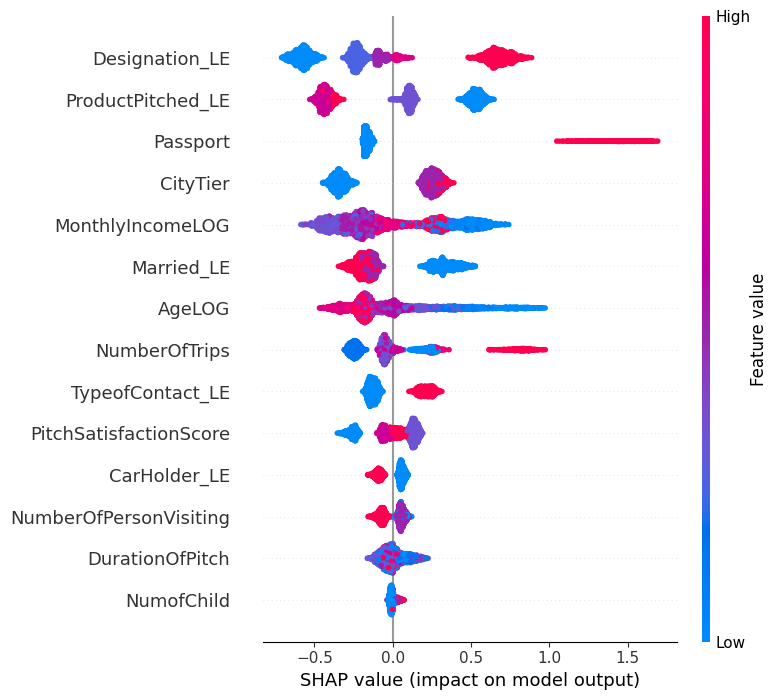

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

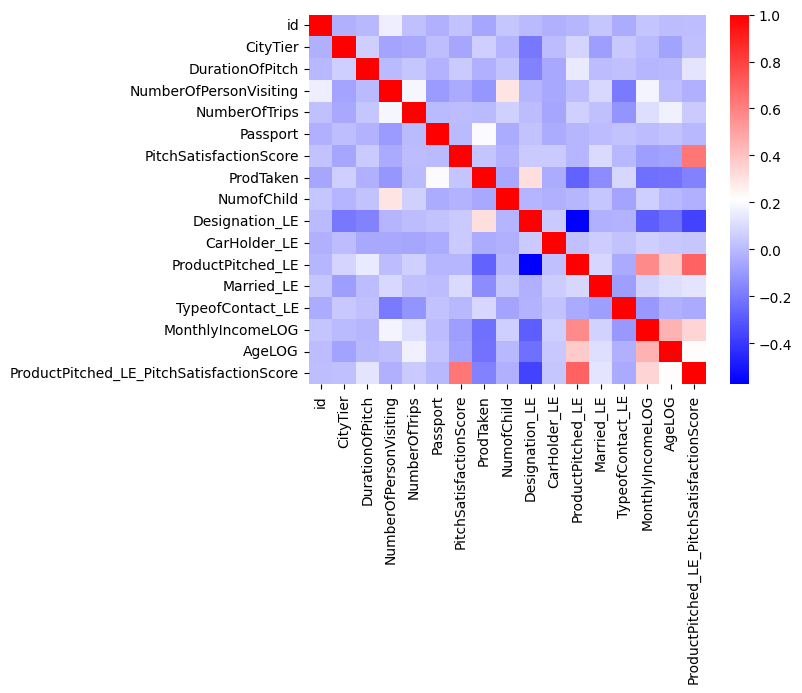

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

[I 2025-05-23 10:30:54,435] A new study created in memory with name: no-name-b295ed81-f9f2-460e-ba1a-22ce7e89280c
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.998186	valid's auc: 0.805011
#########################
### Fold 2
#########################
[100]	train's auc: 0.998902	valid's auc: 0.825458
#########################
### Fold 3
#########################
[100]	train's auc: 0.999145	valid's auc: 0.785583


[I 2025-05-23 10:30:55,191] Trial 0 finished with value: 0.8015872642270737 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 28, 'feature_fraction': 0.7928752632738917, 'bagging_fraction': 0.9015054325833236, 'bagging_freq': 6, 'lambda_l1': 1.4942835088265995e-08, 'lambda_l2': 4.999097764234564e-06, 'max_depth': 9}. Best is trial 0 with value: 0.8015872642270737.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.987278	valid's auc: 0.812129
#########################
### Fold 2
#########################
[100]	train's auc: 0.988498	valid's auc: 0.829464
#########################
### Fold 3
#########################


[I 2025-05-23 10:30:55,831] Trial 1 finished with value: 0.8216343515639289 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 22, 'feature_fraction': 0.6030898634035116, 'bagging_fraction': 0.8115395405039862, 'bagging_freq': 1, 'lambda_l1': 1.0819064098889874e-08, 'lambda_l2': 1.6957070639211197e-08, 'max_depth': 6}. Best is trial 1 with value: 0.8216343515639289.


[100]	train's auc: 0.989712	valid's auc: 0.791996
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.99982	valid's auc: 0.795036
#########################
### Fold 2
#########################
[100]	train's auc: 0.999737	valid's auc: 0.815301
#########################
### Fold 3
#########################


[I 2025-05-23 10:30:56,869] Trial 2 finished with value: 0.8069799142448273 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'feature_fraction': 0.7442016807172265, 'bagging_fraction': 0.6111503676132831, 'bagging_freq': 6, 'lambda_l1': 1.5611898318920095e-05, 'lambda_l2': 0.013132534331446998, 'max_depth': 11}. Best is trial 1 with value: 0.8216343515639289.


[100]	train's auc: 0.99864	valid's auc: 0.76782
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926932	valid's auc: 0.823742
#########################
### Fold 2
#########################
[100]	train's auc: 0.928322	valid's auc: 0.842739
#########################
### Fold 3
#########################
[100]	train's auc: 0.933752	valid's auc: 0.803243


[I 2025-05-23 10:30:57,702] Trial 3 finished with value: 0.8301251358417887 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 75, 'feature_fraction': 0.5019954416140024, 'bagging_fraction': 0.777628985010166, 'bagging_freq': 4, 'lambda_l1': 1.3298108449059503, 'lambda_l2': 3.102758462782083e-07, 'max_depth': 12}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.996992	valid's auc: 0.798129
#########################
### Fold 2
#########################
[100]	train's auc: 0.995814	valid's auc: 0.822431
#########################
### Fold 3
#########################
[100]	train's auc: 0.997275	valid's auc: 0.773237


[I 2025-05-23 10:30:58,404] Trial 4 finished with value: 0.8160897201390158 and parameters: {'num_leaves': 250, 'min_data_in_leaf': 23, 'feature_fraction': 0.8103679046874002, 'bagging_fraction': 0.5617456110375273, 'bagging_freq': 2, 'lambda_l1': 0.07229377813466037, 'lambda_l2': 2.7162688522446555e-06, 'max_depth': 11}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.921499	valid's auc: 0.818933
#########################
### Fold 2
#########################
[100]	train's auc: 0.925132	valid's auc: 0.847645
#########################
### Fold 3
#########################
[100]	train's auc: 0.933545	valid's auc: 0.805101


[I 2025-05-23 10:30:58,920] Trial 5 finished with value: 0.8280545572902657 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 38, 'feature_fraction': 0.544731955095192, 'bagging_fraction': 0.8208361247102827, 'bagging_freq': 4, 'lambda_l1': 0.0013794747159965918, 'lambda_l2': 1.4924966875826364, 'max_depth': 4}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908954	valid's auc: 0.821779
#########################
### Fold 2
#########################
[100]	train's auc: 0.910268	valid's auc: 0.841386
#########################
### Fold 3
#########################
[100]	train's auc: 0.92056	valid's auc: 0.806352


[I 2025-05-23 10:31:02,684] Trial 6 finished with value: 0.821126962308611 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 99, 'feature_fraction': 0.5159775851320532, 'bagging_fraction': 0.579700080595271, 'bagging_freq': 3, 'lambda_l1': 8.626765799395585e-06, 'lambda_l2': 0.0345309682420711, 'max_depth': 11}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.946396	valid's auc: 0.815646
#########################
### Fold 2
#########################
[100]	train's auc: 0.951824	valid's auc: 0.83483
#########################
### Fold 3
#########################
[100]	train's auc: 0.955766	valid's auc: 0.796144


[I 2025-05-23 10:31:03,265] Trial 7 finished with value: 0.8261312527571847 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 25, 'feature_fraction': 0.8295753839831921, 'bagging_fraction': 0.7651688069890838, 'bagging_freq': 1, 'lambda_l1': 0.0001689234079247022, 'lambda_l2': 8.137268765339655e-07, 'max_depth': 4}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.98306	valid's auc: 0.805918
#########################
### Fold 2
#########################
[100]	train's auc: 0.981654	valid's auc: 0.826637
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:04,029] Trial 8 finished with value: 0.8197312215539225 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 47, 'feature_fraction': 0.6412378062323092, 'bagging_fraction': 0.6891229060223041, 'bagging_freq': 7, 'lambda_l1': 0.0009573362735644148, 'lambda_l2': 1.0087722416469642e-08, 'max_depth': 12}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.982006	valid's auc: 0.788893
#########################
### Fold 1
#########################
[100]	train's auc: 0.894649	valid's auc: 0.819331


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888128	valid's auc: 0.848624
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:04,579] Trial 9 finished with value: 0.8285784224060943 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 57, 'feature_fraction': 0.9172622655974704, 'bagging_fraction': 0.5529217618310822, 'bagging_freq': 2, 'lambda_l1': 5.579232442948922e-07, 'lambda_l2': 1.4320859205437713, 'max_depth': 3}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.902355	valid's auc: 0.807488
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.884228	valid's auc: 0.821066
[200]	train's auc: 0.890795	valid's auc: 0.822685
#########################
### Fold 2
#########################
[100]	train's auc: 0.886181	valid's auc: 0.850515
#########################
### Fold 3
#########################
[100]	train's auc: 0.893326	valid's auc: 0.804524


[I 2025-05-23 10:31:05,409] Trial 10 finished with value: 0.8242156817912826 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 80, 'feature_fraction': 0.9785491799554547, 'bagging_fraction': 0.9747580752618656, 'bagging_freq': 5, 'lambda_l1': 6.206415841711431, 'lambda_l2': 8.525265925584997e-05, 'max_depth': 8}. Best is trial 3 with value: 0.8301251358417887.


[200]	train's auc: 0.894337	valid's auc: 0.805314
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.919307	valid's auc: 0.820353
#########################
### Fold 2
#########################
[100]	train's auc: 0.926943	valid's auc: 0.84083
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:06,201] Trial 11 finished with value: 0.8225899514735471 and parameters: {'num_leaves': 19, 'min_data_in_leaf': 67, 'feature_fraction': 0.9950421918275689, 'bagging_fraction': 0.6874802953523638, 'bagging_freq': 3, 'lambda_l1': 8.470881690511204e-07, 'lambda_l2': 5.962856073241754, 'max_depth': 6}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.928871	valid's auc: 0.801275
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882684	valid's auc: 0.824069
#########################
### Fold 2
#########################
[100]	train's auc: 0.880137	valid's auc: 0.849718
#########################
### Fold 3
#########################
[100]	train's auc: 0.894524	valid's auc: 0.816979


[I 2025-05-23 10:31:06,850] Trial 12 finished with value: 0.8306348787914654 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 65, 'feature_fraction': 0.915183919261779, 'bagging_fraction': 0.5136462450821075, 'bagging_freq': 3, 'lambda_l1': 0.7560450234000367, 'lambda_l2': 0.0008962115912066176, 'max_depth': 3}. Best is trial 12 with value: 0.8306348787914654.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897911	valid's auc: 0.820214
#########################
### Fold 2
#########################
[100]	train's auc: 0.899336	valid's auc: 0.847017
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:07,501] Trial 13 finished with value: 0.8258235912803021 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 81, 'feature_fraction': 0.7063617037054764, 'bagging_fraction': 0.6713157975849728, 'bagging_freq': 4, 'lambda_l1': 2.8735944982358617, 'lambda_l2': 0.000710905826405016, 'max_depth': 6}. Best is trial 12 with value: 0.8306348787914654.


[100]	train's auc: 0.908602	valid's auc: 0.8047
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.928077	valid's auc: 0.81341
#########################
### Fold 2
#########################
[100]	train's auc: 0.928963	valid's auc: 0.839162


[I 2025-05-23 10:31:08,078] Trial 14 finished with value: 0.8220519641915666 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 70, 'feature_fraction': 0.8918302353399479, 'bagging_fraction': 0.5038005768063086, 'bagging_freq': 3, 'lambda_l1': 0.1756426791174202, 'lambda_l2': 0.0004924596373060388, 'max_depth': 9}. Best is trial 12 with value: 0.8306348787914654.


#########################
### Fold 3
#########################
[100]	train's auc: 0.931978	valid's auc: 0.801816


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.940209	valid's auc: 0.818383
#########################
### Fold 2
#########################
[100]	train's auc: 0.93766	valid's auc: 0.844062
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:08,736] Trial 15 finished with value: 0.82758314593443 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 98, 'feature_fraction': 0.6832023545922425, 'bagging_fraction': 0.8481514040976948, 'bagging_freq': 4, 'lambda_l1': 0.03236476489932557, 'lambda_l2': 2.1878377384988573e-07, 'max_depth': 7}. Best is trial 12 with value: 0.8306348787914654.


[100]	train's auc: 0.942378	valid's auc: 0.798488
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887872	valid's auc: 0.82718
#########################
### Fold 2
#########################
[100]	train's auc: 0.885994	valid's auc: 0.852117
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:09,414] Trial 16 finished with value: 0.8320729860446099 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 86, 'feature_fraction': 0.9000909798923391, 'bagging_fraction': 0.7526362282133754, 'bagging_freq': 5, 'lambda_l1': 0.5540392083311089, 'lambda_l2': 4.398323045397012e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.898556	valid's auc: 0.806546
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896413	valid's auc: 0.814486
#########################
### Fold 2
#########################
[100]	train's auc: 0.892608	valid's auc: 0.851071


[I 2025-05-23 10:31:09,970] Trial 17 finished with value: 0.8315941773636472 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 59, 'feature_fraction': 0.8803638836584011, 'bagging_fraction': 0.6384337229345436, 'bagging_freq': 5, 'lambda_l1': 0.010633638083245921, 'lambda_l2': 2.799036507117158e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


#########################
### Fold 3
#########################
[100]	train's auc: 0.902409	valid's auc: 0.805963


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918365	valid's auc: 0.818026
#########################
### Fold 2
#########################
[100]	train's auc: 0.92089	valid's auc: 0.841361
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:10,588] Trial 18 finished with value: 0.8281994776143492 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 85, 'feature_fraction': 0.8567792130399556, 'bagging_fraction': 0.6445387439107968, 'bagging_freq': 5, 'lambda_l1': 0.013617037320467897, 'lambda_l2': 2.6533898370324473e-05, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.925631	valid's auc: 0.807579
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926822	valid's auc: 0.82631
#########################
### Fold 2
#########################
[100]	train's auc: 0.926855	valid's auc: 0.840612
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:11,152] Trial 19 finished with value: 0.8272684233744715 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 53, 'feature_fraction': 0.9582327599001603, 'bagging_fraction': 0.7254670039393364, 'bagging_freq': 6, 'lambda_l1': 0.007166527706718746, 'lambda_l2': 2.6527606468349812e-05, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.931622	valid's auc: 0.801488
#########################
### Fold 1
#########################
[100]	train's auc: 0.892636	valid's auc: 0.821833


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.887847	valid's auc: 0.85028
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:11,729] Trial 20 finished with value: 0.8300390578766719 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 90, 'feature_fraction': 0.863473104599277, 'bagging_fraction': 0.8883633726186277, 'bagging_freq': 5, 'lambda_l1': 0.2546764757847371, 'lambda_l2': 0.003391965072320904, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.900844	valid's auc: 0.79915
#########################
### Fold 1
#########################
[100]	train's auc: 0.88519	valid's auc: 0.816256


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.887321	valid's auc: 0.850207
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:12,308] Trial 21 finished with value: 0.8278971960102863 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 64, 'feature_fraction': 0.9296127054859802, 'bagging_fraction': 0.5164033237789603, 'bagging_freq': 5, 'lambda_l1': 0.601513374693202, 'lambda_l2': 0.00014281892281198052, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.893811	valid's auc: 0.810475
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.861533	valid's auc: 0.81289
[200]	train's auc: 0.863809	valid's auc: 0.815634
#########################
### Fold 2
#########################
[100]	train's auc: 0.852862	valid's auc: 0.85886
#########################
### Fold 3
#########################
[100]	train's auc: 0.864905	valid's auc: 0.801955


[I 2025-05-23 10:31:16,022] Trial 22 finished with value: 0.8219383143782482 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 59, 'feature_fraction': 0.8962904958187682, 'bagging_fraction': 0.625500806840011, 'bagging_freq': 7, 'lambda_l1': 8.902793053121568, 'lambda_l2': 0.002702871509022927, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90268	valid's auc: 0.821084
#########################
### Fold 2
#########################
[100]	train's auc: 0.898685	valid's auc: 0.850866
#########################
### Fold 3
#########################
[100]	train's auc: 0.913131	valid's auc: 0.805496


[I 2025-05-23 10:31:16,576] Trial 23 finished with value: 0.8311089800837108 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 47, 'feature_fraction': 0.7814209130146459, 'bagging_fraction': 0.7382549253259105, 'bagging_freq': 3, 'lambda_l1': 0.004193875938870678, 'lambda_l2': 0.07858827790279298, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.949025	valid's auc: 0.816582
#########################
### Fold 2
#########################
[100]	train's auc: 0.953417	valid's auc: 0.832461
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:17,316] Trial 24 finished with value: 0.8236289394118723 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 45, 'feature_fraction': 0.7713523030043306, 'bagging_fraction': 0.7260665721378166, 'bagging_freq': 6, 'lambda_l1': 0.0038712580029909584, 'lambda_l2': 0.032597906892361604, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.949908	valid's auc: 0.799253
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.936856	valid's auc: 0.817936
#########################
### Fold 2
#########################
[100]	train's auc: 0.933188	valid's auc: 0.84199


[I 2025-05-23 10:31:17,961] Trial 25 finished with value: 0.8269002383283659 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 37, 'feature_fraction': 0.7446548108439974, 'bagging_fraction': 0.7338474123580327, 'bagging_freq': 2, 'lambda_l1': 0.00013828048000642614, 'lambda_l2': 0.16799049902515195, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


#########################
### Fold 3
#########################
[100]	train's auc: 0.937801	valid's auc: 0.796107


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906443	valid's auc: 0.824467
[200]	train's auc: 0.936229	valid's auc: 0.815108
#########################
### Fold 2
#########################
[100]	train's auc: 0.899646	valid's auc: 0.846376
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:18,536] Trial 26 finished with value: 0.8279099732082333 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 47, 'feature_fraction': 0.8396064859036039, 'bagging_fraction': 0.7867583398196871, 'bagging_freq': 5, 'lambda_l1': 0.04191069553865129, 'lambda_l2': 1.3333142267071266e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.910552	valid's auc: 0.803383
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.932988	valid's auc: 0.817386
#########################
### Fold 2
#########################
[100]	train's auc: 0.93136	valid's auc: 0.842787
#########################
### Fold 3
#########################
[100]	train's auc: 0.94323	valid's auc: 0.794383


[I 2025-05-23 10:31:19,302] Trial 27 finished with value: 0.8129472019281464 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 35, 'feature_fraction': 0.949508608080646, 'bagging_fraction': 0.6661363845882994, 'bagging_freq': 4, 'lambda_l1': 0.0032491718193661473, 'lambda_l2': 0.0001149144053723656, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.91191	valid's auc: 0.826069
#########################
### Fold 2
#########################
[100]	train's auc: 0.913948	valid's auc: 0.842274
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:20,083] Trial 28 finished with value: 0.8270273378237338 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 91, 'feature_fraction': 0.872977638084202, 'bagging_fraction': 0.5998192693567322, 'bagging_freq': 5, 'lambda_l1': 0.0005019951547116789, 'lambda_l2': 2.3847452028622928e-06, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.917867	valid's auc: 0.806461
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.965206	valid's auc: 0.815827
#########################
### Fold 2
#########################
[100]	train's auc: 0.963516	valid's auc: 0.833132
#########################
### Fold 3
#########################
[100]	train's auc: 0.968931	valid's auc: 0.792251


[I 2025-05-23 10:31:20,740] Trial 29 finished with value: 0.8224154418489548 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 74, 'feature_fraction': 0.7967676629253916, 'bagging_fraction': 0.8660108428604322, 'bagging_freq': 6, 'lambda_l1': 4.108305915431482e-05, 'lambda_l2': 0.2382774509818641, 'max_depth': 8}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901397	valid's auc: 0.828087
[200]	train's auc: 0.928945	valid's auc: 0.825325
#########################
### Fold 2
#########################
[100]	train's auc: 0.892291	valid's auc: 0.85054
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:21,430] Trial 30 finished with value: 0.8279247678584878 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 54, 'feature_fraction': 0.7676012172655995, 'bagging_fraction': 0.7140355126194824, 'bagging_freq': 4, 'lambda_l1': 0.14160307683526072, 'lambda_l2': 6.727882940300058e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.91167	valid's auc: 0.79915
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885788	valid's auc: 0.824564
#########################
### Fold 2
#########################
[100]	train's auc: 0.884513	valid's auc: 0.84941
#########################
### Fold 3
#########################
[100]	train's auc: 0.896699	valid's auc: 0.808909


[I 2025-05-23 10:31:22,189] Trial 31 finished with value: 0.828476204822518 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 62, 'feature_fraction': 0.9181300661898556, 'bagging_fraction': 0.5314826378816688, 'bagging_freq': 3, 'lambda_l1': 0.6879934291733141, 'lambda_l2': 0.002247240171600655, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930759	valid's auc: 0.813066
#########################
### Fold 2
#########################
[100]	train's auc: 0.934837	valid's auc: 0.833718
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:22,804] Trial 32 finished with value: 0.8257640764372329 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 49, 'feature_fraction': 0.8215020111150463, 'bagging_fraction': 0.9261775312024677, 'bagging_freq': 3, 'lambda_l1': 0.012076450686439581, 'lambda_l2': 0.0006716968133030156, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.939511	valid's auc: 0.801749
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887862	valid's auc: 0.822099
#########################
### Fold 2
#########################
[100]	train's auc: 0.884807	valid's auc: 0.851833
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:23,591] Trial 33 finished with value: 0.8243609383574173 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 70, 'feature_fraction': 0.8877249388136844, 'bagging_fraction': 0.6409456445132966, 'bagging_freq': 2, 'lambda_l1': 1.734750635412379, 'lambda_l2': 0.010166162121672396, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.895377	valid's auc: 0.806291
[200]	train's auc: 0.920734	valid's auc: 0.799314


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.951021	valid's auc: 0.807483
#########################
### Fold 2
#########################
[100]	train's auc: 0.955446	valid's auc: 0.831319
#########################
### Fold 3
#########################
[100]	train's auc: 0.955946	valid's auc: 0.79782


[I 2025-05-23 10:31:24,355] Trial 34 finished with value: 0.8232644530283304 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 41, 'feature_fraction': 0.7040460665393147, 'bagging_fraction': 0.7594574841424827, 'bagging_freq': 3, 'lambda_l1': 0.3871182743077282, 'lambda_l2': 2.883562402172342e-05, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930968	valid's auc: 0.81686
#########################
### Fold 2
#########################
[100]	train's auc: 0.931362	valid's auc: 0.840201
#########################
### Fold 3
#########################
[100]	train's auc: 0.937397	valid's auc: 0.799903


[I 2025-05-23 10:31:24,985] Trial 35 finished with value: 0.8265579439202058 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 60, 'feature_fraction': 0.9487225757026483, 'bagging_fraction': 0.8005376595842242, 'bagging_freq': 1, 'lambda_l1': 0.03138267145181586, 'lambda_l2': 1.6647528326849227e-07, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.997244	valid's auc: 0.807791
#########################
### Fold 2
#########################
[100]	train's auc: 0.997433	valid's auc: 0.822999
#########################
### Fold 3
#########################
[100]	train's auc: 0.997017	valid's auc: 0.79202


[I 2025-05-23 10:31:28,980] Trial 36 finished with value: 0.8086665043738366 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 11, 'feature_fraction': 0.8465599645171629, 'bagging_fraction': 0.5924242681665409, 'bagging_freq': 4, 'lambda_l1': 0.07996546331135684, 'lambda_l2': 0.00023702347082484818, 'max_depth': 7}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.997058	valid's auc: 0.809332
#########################
### Fold 2
#########################
[100]	train's auc: 0.995784	valid's auc: 0.816751
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:29,911] Trial 37 finished with value: 0.8081335607226244 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 30, 'feature_fraction': 0.7858653847997926, 'bagging_fraction': 0.7030922907202923, 'bagging_freq': 2, 'lambda_l1': 0.002739316968370737, 'lambda_l2': 0.15490189744255076, 'max_depth': 10}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.996961	valid's auc: 0.779589
#########################
### Fold 1
#########################
[100]	train's auc: 0.880344	valid's auc: 0.827646


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.900208	valid's auc: 0.821978
#########################
### Fold 2
#########################
[100]	train's auc: 0.873282	valid's auc: 0.854201
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:30,567] Trial 38 finished with value: 0.8303188112633018 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 74, 'feature_fraction': 0.9196838368117686, 'bagging_fraction': 0.5612950605565461, 'bagging_freq': 6, 'lambda_l1': 1.9088558341046291, 'lambda_l2': 1.2337926711529732e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.882975	valid's auc: 0.808684
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.95879	valid's auc: 0.810897
#########################
### Fold 2
#########################
[100]	train's auc: 0.965609	valid's auc: 0.827803
#########################
### Fold 3
#########################
[100]	train's auc: 0.966016	valid's auc: 0.797334


[I 2025-05-23 10:31:31,211] Trial 39 finished with value: 0.8227036012868656 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 51, 'feature_fraction': 0.59595299909485, 'bagging_fraction': 0.81770799643155, 'bagging_freq': 3, 'lambda_l1': 0.017519232538127576, 'lambda_l2': 0.011192953001543703, 'max_depth': 6}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.935379	valid's auc: 0.81599
#########################
### Fold 2
#########################
[100]	train's auc: 0.933956	valid's auc: 0.836558
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:31,880] Trial 40 finished with value: 0.8101358821377462 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 32, 'feature_fraction': 0.8132226531137006, 'bagging_fraction': 0.7455949090249344, 'bagging_freq': 4, 'lambda_l1': 0.0011873693948457797, 'lambda_l2': 6.027302049156834e-05, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.944446	valid's auc: 0.804148
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.872898	valid's auc: 0.826933
[200]	train's auc: 0.888852	valid's auc: 0.824014
#########################
### Fold 2
#########################
[100]	train's auc: 0.863196	valid's auc: 0.85121
#########################
### Fold 3
#########################
[100]	train's auc: 0.875764	valid's auc: 0.806492


[I 2025-05-23 10:31:32,566] Trial 41 finished with value: 0.8278067468985033 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 79, 'feature_fraction': 0.9134208098206098, 'bagging_fraction': 0.5540811277697222, 'bagging_freq': 6, 'lambda_l1': 3.3008616484134485, 'lambda_l2': 6.119224594092673e-08, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882297	valid's auc: 0.822854
[200]	train's auc: 0.910669	valid's auc: 0.815162
#########################
### Fold 2
#########################
[100]	train's auc: 0.876717	valid's auc: 0.857839
[200]	train's auc: 0.898768	valid's auc: 0.853549
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:33,311] Trial 42 finished with value: 0.8296382573515961 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 75, 'feature_fraction': 0.969236634513019, 'bagging_fraction': 0.5765503295780882, 'bagging_freq': 7, 'lambda_l1': 0.9887890619654673, 'lambda_l2': 9.224577691588321e-07, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.888802	valid's auc: 0.803625
[200]	train's auc: 0.915433	valid's auc: 0.806589


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90682	valid's auc: 0.813464
#########################
### Fold 2
#########################


[I 2025-05-23 10:31:33,855] Trial 43 finished with value: 0.8261531084905153 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 65, 'feature_fraction': 0.8783594220291566, 'bagging_fraction': 0.5372928346630638, 'bagging_freq': 5, 'lambda_l1': 0.09094312891413638, 'lambda_l2': 3.2805733505816703e-06, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.909117	valid's auc: 0.838395
#########################
### Fold 3
#########################
[100]	train's auc: 0.912338	valid's auc: 0.797984


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875015	valid's auc: 0.822655
#########################
### Fold 2
#########################
[100]	train's auc: 0.867394	valid's auc: 0.851367
#########################
### Fold 3
#########################
[100]	train's auc: 0.877614	valid's auc: 0.803741


[I 2025-05-23 10:31:34,407] Trial 44 finished with value: 0.8272334542011427 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 86, 'feature_fraction': 0.9992241927083311, 'bagging_fraction': 0.5710192214584281, 'bagging_freq': 6, 'lambda_l1': 2.506341792556025, 'lambda_l2': 1.099827801708296e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907283	valid's auc: 0.832371
[200]	train's auc: 0.939492	valid's auc: 0.820214
#########################
### Fold 2
#########################
[100]	train's auc: 0.908066	valid's auc: 0.844346
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:35,084] Trial 45 finished with value: 0.8322616178353542 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 71, 'feature_fraction': 0.9341850265806821, 'bagging_fraction': 0.6178555950161336, 'bagging_freq': 6, 'lambda_l1': 0.3146501801402528, 'lambda_l2': 7.229882468339914e-06, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.913277	valid's auc: 0.806358
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911003	valid's auc: 0.824461
#########################
### Fold 2
#########################
[100]	train's auc: 0.910895	valid's auc: 0.841796
#########################
### Fold 3
#########################
[100]	train's auc: 0.914805	valid's auc: 0.80037


[I 2025-05-23 10:31:35,737] Trial 46 finished with value: 0.8272912878339554 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 70, 'feature_fraction': 0.9388179282236351, 'bagging_fraction': 0.6124208003183419, 'bagging_freq': 5, 'lambda_l1': 3.732875288309584e-08, 'lambda_l2': 1.3108420937981915e-05, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.938185	valid's auc: 0.817271
#########################
### Fold 2
#########################
[100]	train's auc: 0.942742	valid's auc: 0.839247
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:36,395] Trial 47 finished with value: 0.8257523079654396 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 57, 'feature_fraction': 0.9783473643529245, 'bagging_fraction': 0.6799822239525164, 'bagging_freq': 3, 'lambda_l1': 0.2697913122926347, 'lambda_l2': 0.0013082386965489253, 'max_depth': 5}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.948312	valid's auc: 0.795937
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.923979	valid's auc: 0.811017
#########################
### Fold 2
#########################
[100]	train's auc: 0.924653	valid's auc: 0.839174
#########################
### Fold 3
#########################
[100]	train's auc: 0.934755	valid's auc: 0.791765


[I 2025-05-23 10:31:37,020] Trial 48 finished with value: 0.8248387383122263 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 42, 'feature_fraction': 0.900539159797172, 'bagging_fraction': 0.6506177540879807, 'bagging_freq': 4, 'lambda_l1': 0.04439678452836288, 'lambda_l2': 0.8201930705143418, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887101	valid's auc: 0.819773
#########################
### Fold 2
#########################
[100]	train's auc: 0.890094	valid's auc: 0.845778
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:37,700] Trial 49 finished with value: 0.830419347636622 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 93, 'feature_fraction': 0.8359578280519963, 'bagging_fraction': 0.7728683852531713, 'bagging_freq': 7, 'lambda_l1': 0.006570735065457905, 'lambda_l2': 0.048458600740018926, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.898794	valid's auc: 0.805423
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.919114	valid's auc: 0.821295
#########################
### Fold 2
#########################
[100]	train's auc: 0.916684	valid's auc: 0.843325


[I 2025-05-23 10:31:38,309] Trial 50 finished with value: 0.8292794870829253 and parameters: {'num_leaves': 224, 'min_data_in_leaf': 84, 'feature_fraction': 0.8617074446831874, 'bagging_fraction': 0.8387582716917479, 'bagging_freq': 5, 'lambda_l1': 0.00030973459973920544, 'lambda_l2': 0.00027536607484588517, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.


#########################
### Fold 3
#########################
[100]	train's auc: 0.925764	valid's auc: 0.799672


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886343	valid's auc: 0.821833
#########################
### Fold 2
#########################
[100]	train's auc: 0.887076	valid's auc: 0.845458
#########################
### Fold 3
#########################
[100]	train's auc: 0.898421	valid's auc: 0.803492


[I 2025-05-23 10:31:40,770] Trial 51 finished with value: 0.8293928006541926 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 95, 'feature_fraction': 0.8222693348457092, 'bagging_fraction': 0.7795527459698768, 'bagging_freq': 7, 'lambda_l1': 0.0016144485106688107, 'lambda_l2': 0.06451922442916252, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886968	valid's auc: 0.82425
#########################
### Fold 2
#########################
[100]	train's auc: 0.886567	valid's auc: 0.84602
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:42,588] Trial 52 finished with value: 0.830583433757626 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 91, 'feature_fraction': 0.7219949415537702, 'bagging_fraction': 0.7517910557884074, 'bagging_freq': 7, 'lambda_l1': 0.0065228262871405195, 'lambda_l2': 0.006254054367841388, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.895751	valid's auc: 0.808866
#########################
### Fold 1
#########################
[100]	train's auc: 0.882622	valid's auc: 0.822359


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.880596	valid's auc: 0.853609
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:43,128] Trial 53 finished with value: 0.8331973794639495 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 100, 'feature_fraction': 0.670751230136397, 'bagging_fraction': 0.7078553831859342, 'bagging_freq': 6, 'lambda_l1': 0.1365241934892181, 'lambda_l2': 0.0063075352882038535, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.894096	valid's auc: 0.806291
#########################
### Fold 1
#########################
[100]	train's auc: 0.881636	valid's auc: 0.824419


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.882103	valid's auc: 0.853464
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:43,650] Trial 54 finished with value: 0.8321005578928113 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 99, 'feature_fraction': 0.632556220703749, 'bagging_fraction': 0.6968841504487653, 'bagging_freq': 6, 'lambda_l1': 0.17405353578275637, 'lambda_l2': 0.0011532654426631723, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.892495	valid's auc: 0.812048
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882012	valid's auc: 0.825984
#########################
### Fold 2
#########################
[100]	train's auc: 0.880126	valid's auc: 0.853011
#########################
### Fold 3
#########################
[100]	train's auc: 0.892284	valid's auc: 0.81302


[I 2025-05-23 10:31:44,321] Trial 55 finished with value: 0.8301597687730662 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 96, 'feature_fraction': 0.6472733437613111, 'bagging_fraction': 0.6947828520719788, 'bagging_freq': 6, 'lambda_l1': 0.14366733679369928, 'lambda_l2': 5.158848703094287e-05, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.916075	valid's auc: 0.806911
#########################
### Fold 1
#########################
[100]	train's auc: 0.900976	valid's auc: 0.822788


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89684	valid's auc: 0.844074
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:44,843] Trial 56 finished with value: 0.829889766405922 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 99, 'feature_fraction': 0.6128031486320533, 'bagging_fraction': 0.6623515299479814, 'bagging_freq': 6, 'lambda_l1': 0.024622107606666607, 'lambda_l2': 0.022580952549413863, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.902846	valid's auc: 0.809067
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908027	valid's auc: 0.818467
#########################
### Fold 2
#########################
[100]	train's auc: 0.910155	valid's auc: 0.844552
#########################
### Fold 3
#########################
[100]	train's auc: 0.915119	valid's auc: 0.813026


[I 2025-05-23 10:31:45,570] Trial 57 finished with value: 0.8283090925230527 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 88, 'feature_fraction': 0.5479286193511225, 'bagging_fraction': 0.6270633518221421, 'bagging_freq': 6, 'lambda_l1': 0.36215037443783454, 'lambda_l2': 1.046086316395077e-05, 'max_depth': 5}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.94843	valid's auc: 0.803474
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.945318	valid's auc: 0.81486
#########################
### Fold 2
#########################
[100]	train's auc: 0.946991	valid's auc: 0.834111
#########################
### Fold 3
#########################
[100]	train's auc: 0.948892	valid's auc: 0.794954


[I 2025-05-23 10:31:46,247] Trial 58 finished with value: 0.8273652610852279 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 81, 'feature_fraction': 0.640136845921076, 'bagging_fraction': 0.7064507748546662, 'bagging_freq': 5, 'lambda_l1': 0.05822498810258953, 'lambda_l2': 0.005480960854837408, 'max_depth': 12}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.903142	valid's auc: 0.820316
#########################
### Fold 2
#########################
[100]	train's auc: 0.902846	valid's auc: 0.846612
#########################
### Fold 3
#########################
[100]	train's auc: 0.907989	valid's auc: 0.81186


[I 2025-05-23 10:31:46,841] Trial 59 finished with value: 0.8291950903280646 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 96, 'feature_fraction': 0.6635580216736042, 'bagging_fraction': 0.7351807021666614, 'bagging_freq': 6, 'lambda_l1': 0.14014797325883838, 'lambda_l2': 0.00138071444863187, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865594	valid's auc: 0.823803
[200]	train's auc: 0.873162	valid's auc: 0.824993
#########################
### Fold 2
#########################
[100]	train's auc: 0.856904	valid's auc: 0.854171
[200]	train's auc: 0.872444	valid's auc: 0.853984
#########################
### Fold 3
#########################
[100]	train's auc: 0.868857	valid's auc: 0.809473


[I 2025-05-23 10:31:47,753] Trial 60 finished with value: 0.8300908391525624 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 100, 'feature_fraction': 0.6104361901425109, 'bagging_fraction': 0.6787636794696199, 'bagging_freq': 5, 'lambda_l1': 5.583748804516758, 'lambda_l2': 0.0003881032991015012, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.882687	valid's auc: 0.809753
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889138	valid's auc: 0.822431
#########################
### Fold 2
#########################
[100]	train's auc: 0.885633	valid's auc: 0.852026
#########################
### Fold 3
#########################
[100]	train's auc: 0.897374	valid's auc: 0.807785


[I 2025-05-23 10:31:48,363] Trial 61 finished with value: 0.8317589359687537 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 77, 'feature_fraction': 0.7262678588200502, 'bagging_fraction': 0.7156118772819468, 'bagging_freq': 6, 'lambda_l1': 0.8208106680661582, 'lambda_l2': 0.00013285658174085947, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890404	valid's auc: 0.81993
#########################
### Fold 2
#########################
[100]	train's auc: 0.885546	valid's auc: 0.85312
#########################
### Fold 3
#########################
[100]	train's auc: 0.896797	valid's auc: 0.808198


[I 2025-05-23 10:31:48,911] Trial 62 finished with value: 0.8307818165678563 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 77, 'feature_fraction': 0.6820451787807855, 'bagging_fraction': 0.7205708064135441, 'bagging_freq': 6, 'lambda_l1': 0.5405646488467246, 'lambda_l2': 0.00017209307732148408, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906729	valid's auc: 0.818751
#########################
### Fold 2
#########################
[100]	train's auc: 0.909999	valid's auc: 0.845482
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:49,580] Trial 63 finished with value: 0.828989310192707 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 69, 'feature_fraction': 0.7158087330209408, 'bagging_fraction': 0.6512371844068484, 'bagging_freq': 6, 'lambda_l1': 0.96726921892382, 'lambda_l2': 3.6619149776598414e-05, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.912993	valid's auc: 0.804712
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88735	valid's auc: 0.82286
#########################
### Fold 2
#########################
[100]	train's auc: 0.884563	valid's auc: 0.847077
#########################
### Fold 3
#########################
[100]	train's auc: 0.894791	valid's auc: 0.805344


[I 2025-05-23 10:31:50,251] Trial 64 finished with value: 0.8324310838291782 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 84, 'feature_fraction': 0.728762354745762, 'bagging_fraction': 0.6940769787397759, 'bagging_freq': 7, 'lambda_l1': 0.08257889924985777, 'lambda_l2': 0.00010075912804330137, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882451	valid's auc: 0.823634
#########################
### Fold 2
#########################


[I 2025-05-23 10:31:50,761] Trial 65 finished with value: 0.8352837613918808 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 84, 'feature_fraction': 0.6877686207620288, 'bagging_fraction': 0.6277957401741642, 'bagging_freq': 7, 'lambda_l1': 0.21019764697519355, 'lambda_l2': 5.760575622602168e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.885775	valid's auc: 0.85524
#########################
### Fold 3
#########################
[100]	train's auc: 0.890977	valid's auc: 0.808648


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.871214	valid's auc: 0.82509
#########################
### Fold 2
#########################
[100]	train's auc: 0.8687	valid's auc: 0.851899
#########################
### Fold 3
#########################
[100]	train's auc: 0.878205	valid's auc: 0.808678


[I 2025-05-23 10:31:51,366] Trial 66 finished with value: 0.8296100130192924 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 83, 'feature_fraction': 0.7308775452588073, 'bagging_fraction': 0.6958011838635411, 'bagging_freq': 7, 'lambda_l1': 4.570273072768534, 'lambda_l2': 9.449036248693753e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898156	valid's auc: 0.818383
#########################
### Fold 2
#########################
[100]	train's auc: 0.901096	valid's auc: 0.846654
#########################
### Fold 3
#########################
[100]	train's auc: 0.903524	valid's auc: 0.811988


[I 2025-05-23 10:31:51,930] Trial 67 finished with value: 0.8313453582457311 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 89, 'feature_fraction': 0.6960258339031654, 'bagging_fraction': 0.6275806378081876, 'bagging_freq': 7, 'lambda_l1': 0.24109827349799512, 'lambda_l2': 5.084809205108846e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.943222	valid's auc: 0.816256
#########################
### Fold 2
#########################
[100]	train's auc: 0.946605	valid's auc: 0.836431
#########################
### Fold 3
#########################
[100]	train's auc: 0.946561	valid's auc: 0.800978


[I 2025-05-23 10:31:55,751] Trial 68 finished with value: 0.8257882858649221 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 78, 'feature_fraction': 0.7595594504358323, 'bagging_fraction': 0.6591194465685202, 'bagging_freq': 7, 'lambda_l1': 2.1561753201861296e-06, 'lambda_l2': 2.1206293111486136e-05, 'max_depth': 10}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886565	valid's auc: 0.824794
#########################
### Fold 2
#########################
[100]	train's auc: 0.884572	valid's auc: 0.84979
#########################
### Fold 3
#########################
[100]	train's auc: 0.894248	valid's auc: 0.805465


[I 2025-05-23 10:31:56,488] Trial 69 finished with value: 0.8302098688387007 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 87, 'feature_fraction': 0.6667351691265458, 'bagging_fraction': 0.797402160701712, 'bagging_freq': 7, 'lambda_l1': 1.2011862060303797, 'lambda_l2': 4.554295505071349e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.917552	valid's auc: 0.822226
#########################
### Fold 2
#########################
[100]	train's auc: 0.923872	valid's auc: 0.839549
#########################
### Fold 3
#########################
[100]	train's auc: 0.922149	valid's auc: 0.802302


[I 2025-05-23 10:31:57,123] Trial 70 finished with value: 0.8278339825046536 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 83, 'feature_fraction': 0.7364066820421049, 'bagging_fraction': 0.6022707265389102, 'bagging_freq': 6, 'lambda_l1': 0.11434330011052297, 'lambda_l2': 0.00048510439870461526, 'max_depth': 6}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880503	valid's auc: 0.826806
#########################
### Fold 2
#########################
[100]	train's auc: 0.875373	valid's auc: 0.853367
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:57,839] Trial 71 finished with value: 0.8322041204445927 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 93, 'feature_fraction': 0.6272375333749726, 'bagging_fraction': 0.6335842137522003, 'bagging_freq': 6, 'lambda_l1': 0.586886140987925, 'lambda_l2': 9.048413843780127e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.886696	valid's auc: 0.814228
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.879433	valid's auc: 0.824099
#########################
### Fold 2
#########################
[100]	train's auc: 0.879254	valid's auc: 0.852256
#########################
### Fold 3
#########################
[100]	train's auc: 0.892229	valid's auc: 0.814605


[I 2025-05-23 10:31:58,453] Trial 72 finished with value: 0.8300276256469299 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 93, 'feature_fraction': 0.5906475894567681, 'bagging_fraction': 0.6821763525574859, 'bagging_freq': 6, 'lambda_l1': 0.6778528430912948, 'lambda_l2': 9.06490369361172e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[200]	train's auc: 0.913802	valid's auc: 0.806121
#########################
### Fold 1
#########################
[100]	train's auc: 0.878064	valid's auc: 0.822703


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.881589	valid's auc: 0.855929
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:59,007] Trial 73 finished with value: 0.823865990057995 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 94, 'feature_fraction': 0.6302286306794637, 'bagging_fraction': 0.6147410730717608, 'bagging_freq': 7, 'lambda_l1': 0.4023072705999886, 'lambda_l2': 3.425494502842127e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.885427	valid's auc: 0.809364
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896733	valid's auc: 0.821785
#########################
### Fold 2
#########################
[100]	train's auc: 0.900146	valid's auc: 0.847307
#########################
### Fold 3
#########################
[100]	train's auc: 0.906685	valid's auc: 0.808733


[I 2025-05-23 10:31:59,644] Trial 74 finished with value: 0.8284610739302124 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 97, 'feature_fraction': 0.5617478028084967, 'bagging_fraction': 0.7195334885496948, 'bagging_freq': 6, 'lambda_l1': 0.21723353217493033, 'lambda_l2': 1.7603649937869932e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881613	valid's auc: 0.825839
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:00,191] Trial 75 finished with value: 0.8312807997718934 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 91, 'feature_fraction': 0.6567348146983791, 'bagging_fraction': 0.7645075627445842, 'bagging_freq': 7, 'lambda_l1': 1.4329975283308733, 'lambda_l2': 7.147535047811485e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.881922	valid's auc: 0.847204
#########################
### Fold 3
#########################
[100]	train's auc: 0.890439	valid's auc: 0.806953


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.862354	valid's auc: 0.82376
[200]	train's auc: 0.867556	valid's auc: 0.82344
#########################
### Fold 2
#########################
[100]	train's auc: 0.849968	valid's auc: 0.858104
[200]	train's auc: 0.854199	valid's auc: 0.858775
#########################
### Fold 3
#########################
[100]	train's auc: 0.869417	valid's auc: 0.810901


[I 2025-05-23 10:32:00,889] Trial 76 finished with value: 0.830502735665329 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 20, 'feature_fraction': 0.6220754125913327, 'bagging_fraction': 0.7103268526071225, 'bagging_freq': 6, 'lambda_l1': 8.722562573048004, 'lambda_l2': 1.8748445698343525e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.909087	valid's auc: 0.821156
#########################
### Fold 2
#########################
[100]	train's auc: 0.912138	valid's auc: 0.843386
#########################
### Fold 3
#########################
[100]	train's auc: 0.914374	valid's auc: 0.807725


[I 2025-05-23 10:32:01,546] Trial 77 finished with value: 0.828117434553847 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 100, 'feature_fraction': 0.6897550151607652, 'bagging_fraction': 0.5904288969944084, 'bagging_freq': 6, 'lambda_l1': 0.06304709195726119, 'lambda_l2': 0.00014674850348880676, 'max_depth': 7}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8898	valid's auc: 0.821936
#########################
### Fold 2
#########################
[100]	train's auc: 0.890124	valid's auc: 0.844781
#########################
### Fold 3
#########################
[100]	train's auc: 0.896701	valid's auc: 0.805484


[I 2025-05-23 10:32:02,160] Trial 78 finished with value: 0.8287061943855647 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 86, 'feature_fraction': 0.6827501625087438, 'bagging_fraction': 0.7410934408506427, 'bagging_freq': 7, 'lambda_l1': 2.8804713718075456, 'lambda_l2': 4.612777975749478e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887279	valid's auc: 0.823754
#########################
### Fold 2
#########################
[100]	train's auc: 0.883824	valid's auc: 0.851857
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:02,796] Trial 79 finished with value: 0.8309785181678304 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 73, 'feature_fraction': 0.5842963309701442, 'bagging_fraction': 0.6360418593074568, 'bagging_freq': 6, 'lambda_l1': 0.43973260501938155, 'lambda_l2': 0.0011468204344348108, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.892716	valid's auc: 0.809255
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883755	valid's auc: 0.820292
#########################
### Fold 2
#########################
[100]	train's auc: 0.88146	valid's auc: 0.853246
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:03,363] Trial 80 finished with value: 0.8339166012115473 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 90, 'feature_fraction': 0.751905116138127, 'bagging_fraction': 0.6669821500991377, 'bagging_freq': 7, 'lambda_l1': 0.024313208227841564, 'lambda_l2': 6.25280151753658e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.893885	valid's auc: 0.81036
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88491	valid's auc: 0.824105
#########################
### Fold 2
#########################
[100]	train's auc: 0.886211	valid's auc: 0.848697


[I 2025-05-23 10:32:03,920] Trial 81 finished with value: 0.8314021831523903 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 81, 'feature_fraction': 0.672694623831672, 'bagging_fraction': 0.6717983935949989, 'bagging_freq': 7, 'lambda_l1': 0.020040558755170614, 'lambda_l2': 6.196706755913862e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


#########################
### Fold 3
#########################
[100]	train's auc: 0.897486	valid's auc: 0.806382


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885861	valid's auc: 0.824788
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:04,439] Trial 82 finished with value: 0.8276567829436512 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 89, 'feature_fraction': 0.701526478996452, 'bagging_fraction': 0.6933658356449105, 'bagging_freq': 7, 'lambda_l1': 0.09131969279272799, 'lambda_l2': 5.623405998644672e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.883482	valid's auc: 0.85031
#########################
### Fold 3
#########################
[100]	train's auc: 0.893356	valid's auc: 0.807275


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902118	valid's auc: 0.826739
[200]	train's auc: 0.929623	valid's auc: 0.818715
#########################
### Fold 2
#########################
[100]	train's auc: 0.901271	valid's auc: 0.848038
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:05,074] Trial 83 finished with value: 0.829873963029514 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 91, 'feature_fraction': 0.7499452102760176, 'bagging_fraction': 0.6665271807080477, 'bagging_freq': 6, 'lambda_l1': 0.2077143455293451, 'lambda_l2': 1.6458345869367908e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.909699	valid's auc: 0.811605
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.884916	valid's auc: 0.822546
#########################
### Fold 2
#########################
[100]	train's auc: 0.884957	valid's auc: 0.851772
#########################
### Fold 3
#########################
[100]	train's auc: 0.894693	valid's auc: 0.80804


[I 2025-05-23 10:32:08,647] Trial 84 finished with value: 0.8320702961082 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 84, 'feature_fraction': 0.798523069091603, 'bagging_fraction': 0.6562909130948558, 'bagging_freq': 7, 'lambda_l1': 0.035095185560610004, 'lambda_l2': 3.3498902662358656e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895349	valid's auc: 0.828135
#########################
### Fold 2
#########################
[100]	train's auc: 0.900585	valid's auc: 0.84837
#########################
### Fold 3
#########################
[100]	train's auc: 0.90145	valid's auc: 0.807026


[I 2025-05-23 10:32:09,342] Trial 85 finished with value: 0.8303329334294538 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 98, 'feature_fraction': 0.7104167363834896, 'bagging_fraction': 0.6422748421535021, 'bagging_freq': 7, 'lambda_l1': 0.03927920364604185, 'lambda_l2': 3.903671910954323e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884191	valid's auc: 0.825404
[200]	train's auc: 0.912153	valid's auc: 0.825138
#########################
### Fold 2
#########################
[100]	train's auc: 0.881904	valid's auc: 0.853808
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:10,024] Trial 86 finished with value: 0.8333618018270048 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 84, 'feature_fraction': 0.7627949682954331, 'bagging_fraction': 0.6230593262747294, 'bagging_freq': 7, 'lambda_l1': 0.01236937933042989, 'lambda_l2': 1.492217078756669e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.892432	valid's auc: 0.803953
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893904	valid's auc: 0.822063
[200]	train's auc: 0.925996	valid's auc: 0.818649
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:10,646] Trial 87 finished with value: 0.8283850832266324 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 93, 'feature_fraction': 0.6482217990118082, 'bagging_fraction': 0.6170444071668094, 'bagging_freq': 7, 'lambda_l1': 0.01473429908140511, 'lambda_l2': 1.6388280322376148e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.900876	valid's auc: 0.846503
#########################
### Fold 3
#########################
[100]	train's auc: 0.89998	valid's auc: 0.808642


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877718	valid's auc: 0.819839
#########################
### Fold 2
#########################
[100]	train's auc: 0.875529	valid's auc: 0.858207
#########################
### Fold 3
#########################
[100]	train's auc: 0.886782	valid's auc: 0.806674


[I 2025-05-23 10:32:11,239] Trial 88 finished with value: 0.8264150410484296 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 88, 'feature_fraction': 0.5773783139299137, 'bagging_fraction': 0.5860585144298929, 'bagging_freq': 7, 'lambda_l1': 0.06630360477276534, 'lambda_l2': 3.186295711606791e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.965436	valid's auc: 0.819652
#########################
### Fold 2
#########################
[100]	train's auc: 0.965806	valid's auc: 0.837289
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:11,930] Trial 89 finished with value: 0.8252237354608937 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 94, 'feature_fraction': 0.7698205727446242, 'bagging_fraction': 0.9933690243079388, 'bagging_freq': 7, 'lambda_l1': 0.008566180485286163, 'lambda_l2': 8.583148439949803e-06, 'max_depth': 9}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.962289	valid's auc: 0.797947
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.879474	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.880609	valid's auc: 0.849833
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:12,534] Trial 90 finished with value: 0.8270064908165571 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 86, 'feature_fraction': 0.759249148045978, 'bagging_fraction': 0.6091617166595328, 'bagging_freq': 5, 'lambda_l1': 0.32969776526096023, 'lambda_l2': 0.002290056097201433, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.887829	valid's auc: 0.805708
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883955	valid's auc: 0.825114
#########################
### Fold 2
#########################
[100]	train's auc: 0.887689	valid's auc: 0.849065
#########################
### Fold 3
#########################
[100]	train's auc: 0.894754	valid's auc: 0.809328


[I 2025-05-23 10:32:13,138] Trial 91 finished with value: 0.8327353828855486 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 83, 'feature_fraction': 0.7939495521642269, 'bagging_fraction': 0.6577999057259475, 'bagging_freq': 7, 'lambda_l1': 0.03387404158442147, 'lambda_l2': 2.6208346008073394e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883494	valid's auc: 0.824069
#########################
### Fold 2
#########################
[100]	train's auc: 0.882113	valid's auc: 0.856346
#########################
### Fold 3
#########################
[100]	train's auc: 0.891599	valid's auc: 0.804378


[I 2025-05-23 10:32:13,696] Trial 92 finished with value: 0.8339324045879555 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 82, 'feature_fraction': 0.7405419808632228, 'bagging_fraction': 0.6323541670154665, 'bagging_freq': 7, 'lambda_l1': 0.16663199536254245, 'lambda_l2': 6.794686929904012e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886447	valid's auc: 0.822171
#########################
### Fold 2
#########################
[100]	train's auc: 0.887674	valid's auc: 0.852546
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:14,364] Trial 93 finished with value: 0.8313914234067507 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 80, 'feature_fraction': 0.780701585266176, 'bagging_fraction': 0.6304941828515656, 'bagging_freq': 7, 'lambda_l1': 0.11024905112864052, 'lambda_l2': 2.0720019284095222e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.894486	valid's auc: 0.803237
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885593	valid's auc: 0.824479
#########################
### Fold 2
#########################
[100]	train's auc: 0.887492	valid's auc: 0.850848
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:14,885] Trial 94 finished with value: 0.828862210697339 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 83, 'feature_fraction': 0.7382960630581127, 'bagging_fraction': 0.6464028027761428, 'bagging_freq': 7, 'lambda_l1': 0.15127358237356361, 'lambda_l2': 1.6841278714278536e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.89319	valid's auc: 0.802405
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.9132	valid's auc: 0.823102
#########################
### Fold 2
#########################
[100]	train's auc: 0.915761	valid's auc: 0.838201
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:15,645] Trial 95 finished with value: 0.8287919361086303 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 72, 'feature_fraction': 0.8035085478961029, 'bagging_fraction': 0.6697880786513419, 'bagging_freq': 7, 'lambda_l1': 0.055387054892310515, 'lambda_l2': 5.000367153348004e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.917101	valid's auc: 0.802733
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882776	valid's auc: 0.827331
#########################
### Fold 2
#########################
[100]	train's auc: 0.877968	valid's auc: 0.854231


[I 2025-05-23 10:32:16,171] Trial 96 finished with value: 0.8336835854700395 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 92, 'feature_fraction': 0.750832853267395, 'bagging_fraction': 0.6197395462676234, 'bagging_freq': 7, 'lambda_l1': 0.027097300531106514, 'lambda_l2': 1.13162099856547e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


#########################
### Fold 3
#########################
[100]	train's auc: 0.887453	valid's auc: 0.806844


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884214	valid's auc: 0.820044
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:16,650] Trial 97 finished with value: 0.8251840588988475 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 76, 'feature_fraction': 0.7515872870655759, 'bagging_fraction': 0.6021147877002936, 'bagging_freq': 7, 'lambda_l1': 0.017086494180367364, 'lambda_l2': 6.570780731278864e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.886847	valid's auc: 0.854086
#########################
### Fold 3
#########################
[100]	train's auc: 0.892461	valid's auc: 0.804955


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905807	valid's auc: 0.819996
#########################
### Fold 2
#########################
[100]	train's auc: 0.905289	valid's auc: 0.841549
#########################
### Fold 3
#########################
[100]	train's auc: 0.911735	valid's auc: 0.802296


[I 2025-05-23 10:32:17,300] Trial 98 finished with value: 0.8245041774712445 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 79, 'feature_fraction': 0.7809797647161618, 'bagging_fraction': 0.6207097484815051, 'bagging_freq': 7, 'lambda_l1': 0.005370348061725948, 'lambda_l2': 2.866444977397771e-07, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[200]	train's auc: 0.945551	valid's auc: 0.799447
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917287	valid's auc: 0.815362
#########################
### Fold 2
#########################
[100]	train's auc: 0.917489	valid's auc: 0.842147
#########################
### Fold 3
#########################
[100]	train's auc: 0.919166	valid's auc: 0.802715


[I 2025-05-23 10:32:17,954] Trial 99 finished with value: 0.8274883256759811 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 90, 'feature_fraction': 0.7180514046063774, 'bagging_fraction': 0.5710595726257782, 'bagging_freq': 7, 'lambda_l1': 0.024622180393209705, 'lambda_l2': 2.2929149200937016e-05, 'max_depth': 8}. Best is trial 65 with value: 0.8352837613918808.


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 183, 'min_data_in_leaf': 84, 'feature_fraction': 0.6877686207620288, 'bagging_fraction': 0.6277957401741642, 'bagging_freq': 7, 'lambda_l1': 0.21019764697519355, 'lambda_l2': 5.760575622602168e-06, 'max_depth': 3}
[0.8352837613918808]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.826834107378996, # 7回
    'num_leaves': 194, # 20回
    'bagging_fraction': 0.7716808474830246,
    'bagging_freq': 5,
    'lambda_l1': 0.016961615788790314,
    'lambda_l2': 0.0014606022980008927,
    'min_data_in_leaf': 62,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    'max_depth': 3,
    }

for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.895678	valid's auc: 0.811906
#########################
### Fold 2
#########################
[100]	train's auc: 0.887148	valid's auc: 0.851035
#########################
### Fold 3
#########################
[100]	train's auc: 0.904398	valid's auc: 0.810208
CPU times: user 21.2 s, sys: 389 ms, total: 21.6 s
Wall time: 3.31 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8290831217250025


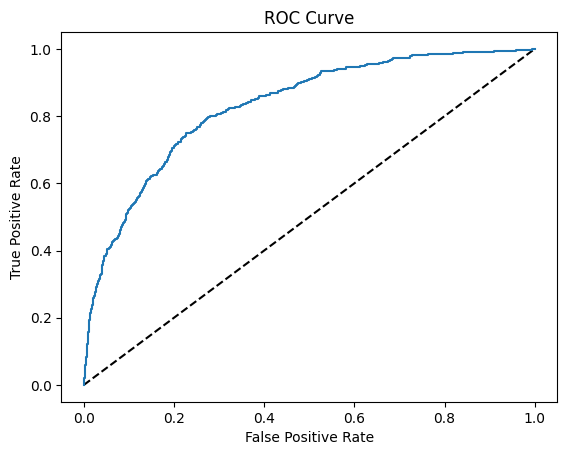

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)